# CMIP6 visualizations

6/12/24 | ZG

Something is wrong, because the plots are identical for all the SSPs

# Step 1: visualize runoff predicted by all ssps using mri-esm2-0_r1i1p1f1

In [3]:
# Import packages
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import os

### Functions

In [4]:
# # Function: load the dataset
# def open_series(fpath_stem, which_date, which_gcm, which_ssp):
#     this_fpath = fpath_stem+'{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_ssp)
#     this_ds = xr.open_dataset(this_fpath)
#     return this_ds

In [5]:
# Function: load the dataset
def open_series(fpath_stem, which_date, which_gcm, which_ssp):
    # Update the file path format to match the changes in the previous cell
    this_fpath = os.path.expanduser(fpath_stem + '{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_ssp))
    this_ds = xr.open_dataset(this_fpath)
    return this_ds

In [6]:
# I assume I need newer files for this?
# Function: calculate runoff
def calc_seasonal(this_ds): # do everything below without the function
    melt1 = this_ds.melt_on_glacier_monthly
    melt2 = this_ds.melt_off_glacier_monthly
    melt3 = this_ds.liq_prcp_off_glacier_monthly
    melt4 = this_ds.liq_prcp_on_glacier_monthly
    
    this_sum = melt1.sum(dim='rgi_id').dropna(dim='time') + melt2.sum(dim='rgi_id').dropna(dim='time') + melt3.sum(dim='rgi_id').dropna(dim='time') + melt4.sum(dim='rgi_id').dropna(dim='time')
    nonzero_sum = this_sum.where(this_sum!=0, drop=True)
    nonzero_sum *= 1e-9


    return nonzero_sum

In [7]:
# Function: select a year and take the mean runoff of all gcms for this year
def season_sliced(keys, dictionary, time):
    new_df = pd.DataFrame()
    for k in keys:
        new = dictionary[k]
        new = new[time]
        new = pd.DataFrame(new)
        new_df[k] = new
    new_df['mean'] = new_df.transpose().mean()
    return new_df

In [8]:
# Make a function that calculates a given runoff value, which I can visualize later
def rtype_calc_monthly(keys, dictionary, runoff):
    dataframe = pd.DataFrame()
    for k in keys:
        rtype_gcm = dictionary[k]
        rtype = rtype_gcm[runoff]
        rtype = pd.DataFrame(rtype)
        dataframe[k] = rtype
    dataframe['mean'] = dataframe.transpose().mean()
    return dataframe

In [9]:
# Make a function that calculates a given runoff value, which I can visualize later
def rtype_calc_monthly_2vars(keys, dictionary, runoff1, runoff2):
    dataframe = pd.DataFrame()
    for k in keys:
        rtype_gcm = dictionary[k]
        rtype1 = rtype_gcm[runoff1]
        rtype2 = rtype_gcm[runoff2]
        rsum = rtype1 + rtype2
        rtype_sum = pd.DataFrame(rsum)
        dataframe[k] = rtype_sum
    dataframe['mean'] = dataframe.transpose().mean()
    return dataframe

In [10]:
# Define variables that will be used for each test
base = '/Users/ziggygoddard/Documents/summer24/'

gcm_list = ['mri-esm2-0_r1i1p1f1'] 

date_list = ['2024-06-12'] # export date (date I downloaded the data)

ssp_list = ['ssp126', 'ssp370','ssp585'] # this stays the same

# gcm_w60 = ['mri-esm2-0_r1i1p1f1'] # not sure what gcm_w60 is/if I need it anymore

all_monthly_dict = {}

# These have to be files that I have downloaded

## Try to make a mega-dictionary with all ssps

In [11]:
# create dictionary
all_monthly_dict = {}

In [12]:
x=0
ssp = ['ssp126', 'ssp370','ssp585']

# Iterate over all combinations of GCMs, dates, and ssp scenarios
# "r" switched to "s"
for gcm in gcm_list:
    for date in date_list:
        for s in ssp_list:
            # Generate the file path
            filepath = base + '{}-gcm_data_{}_{}_compiled_output.nc'.format(date, gcm, s)
            # Check if the file exists
            if os.path.exists(filepath):
                # Open dataset and store in dictionary
                ssp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_ssp=s)
                k = '{}-{}'.format(gcm, s)
                all_monthly_dict[k] = ssp_value

In [13]:
# x=0
# ssp = ['ssp26', 'ssp45', 'ssp60', 'ssp85']

# for r in ssp:
#     x = 0
#     for gcm in gcm_list:
#         if r != 'ssp60':
#             ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=r)
#             k = '{}-{}'.format(gcm, r)
#             all_monthly_dict[k] = ssp_value
#         else:
#             if gcm in gcm_w60:
#                 ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=r)
#                 k = '{}-{}'.format(gcm, r)
#                 all_monthly_dict[k]=ssp_value
#         x += 1

In [14]:
x=0
ssp = ['ssp126', 'ssp370','ssp585']

for s in ssp:
    x = 0
    for gcm in gcm_list:
        ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=s)
        k = '{}-{}'.format(gcm, s)
        all_monthly_dict[k] = ssp_value
        
    x += 1

In [15]:
# Define keys
keys_all = all_monthly_dict.keys()

In [16]:
all_unrolled = {}
for k in keys_all:
    calculation = calc_seasonal(all_monthly_dict[k])
    z = '{}'.format(k)
    all_unrolled[z] = calculation

Roll values for plotting

In [17]:
n_roll = 3 # this is the roll value for all the plots

dict_roll_all = {}
dict_plot_all = {}

for k in keys_all:
    season_roll = all_unrolled[k].roll(month_2d=n_roll, roll_coords=True) # check about these
    season_forplot = all_unrolled[k].roll(month_2d=n_roll, roll_coords=True) 
    name = '{}'.format(k)
    dict_roll_all[name] = season_roll
    dict_plot_all[name] = season_forplot

In [18]:
dict_roll_all

{'mri-esm2-0_r1i1p1f1-ssp126': <xarray.DataArray (time: 81, month_2d: 12)> Size: 4kB
 array([[8.99941063e+00, 1.20390282e+01, 1.66127663e+01, 1.80041599e+01,
         1.46102371e+01, 8.81342602e+00, 5.56925058e+00, 2.15781522e+00,
         1.01832680e-01, 1.49818838e-01, 1.96281210e-01, 4.19290590e+00],
        [1.01367359e+01, 1.11781597e+01, 1.18271027e+01, 1.40965834e+01,
         1.33349104e+01, 7.91780710e+00, 6.18942547e+00, 1.42081499e+00,
         9.16064158e-02, 4.02938724e-02, 2.14820892e-01, 3.30335903e+00],
        [4.95397377e+00, 1.08127079e+01, 1.47945280e+01, 1.22305861e+01,
         1.08411798e+01, 1.04562578e+01, 3.76884031e+00, 4.83149618e-01,
         4.35064062e-02, 6.33053631e-02, 9.71728742e-01, 3.61162186e+00],
        [1.10364933e+01, 1.25111513e+01, 1.35994158e+01, 9.40830803e+00,
         7.94512272e+00, 8.53127003e+00, 5.72765446e+00, 4.05501306e-01,
         2.48465478e-01, 1.53422907e-01, 1.07171130e+00, 5.34574175e+00],
        [1.11422615e+01, 1.34307642

Take sum over rgi id

In [19]:
# Roll and sum
rtype_all = {}
#n_roll = o # this isn't necessary anymore

for k in keys_all:
    rtype_season = all_monthly_dict[k].roll(roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_all[rtype_name] = rtype_sum

In [20]:
# # Not sur how to alter this one either
# # Make a dictionary with all data for all GCMs for each ssp
# # Modified - ensures that only valid file paths are attempted to be opened
# ssp_monthly_dict = {}

# for ssp in ssp_list:
#     ssp_dict = {}
#     for gcm in gcm_list:
#         for date in date_list:
#             # Check if the ssp is not 'ssp60' or the GCM is in gcm_w60
#             if ssp != 'ssp60' or gcm in gcm_w60:
#                 filepath = base + '{}-gcm_data_{}_{}_compiled_output.nc'.format(date, gcm, ssp)
#                 # Check if the file exists before attempting to open it
#                 if os.path.exists(filepath):
#                     ssp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_ssp=ssp)
#                     k = '{}-{}'.format(gcm, ssp)
#                     ssp_dict[k] = ssp_value
#     ssp_monthly_dict[ssp] = ssp_dict

In [21]:
# Not sur how to alter this one either
# Make a dictionary with all data for all GCMs for each ssp
# Modified - ensures that only valid file paths are attempted to be opened
ssp_monthly_dict = {}

for ssp in ssp_list:
    ssp_dict = {}
    for gcm in gcm_list:
        for date in date_list:
            filepath = base + '{}-gcm_data_{}_{}_compiled_output.nc'.format(date, gcm, ssp)
                # Check if the file exists before attempting to open it
            if os.path.exists(filepath):
                ssp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_ssp=ssp)
                k = '{}-{}'.format(gcm, ssp)
                ssp_dict[k] = ssp_value
    ssp_monthly_dict[ssp] = ssp_dict

# Calculate ssp126

In [22]:
# # Make a dictionary with all data for all GCMs (this will only output one ssp!)
# ssp_monthly_dict26 = {}

# x=0
# ssp = 'ssp26'

# # Per ssp:
# for gcm in gcm_list:
#     if ssp != 'ssp60':
#         ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=ssp)
#         k = '{}-{}'.format(gcm, ssp)
#         ssp_monthly_dict26[k]=ssp_value
#     else:
#         if gcm in gcm_w60:
#             ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=ssp)
#             k = '{}-{}'.format(gcm, ssp)
#             ssp_monthly_dict26[k]=ssp_value
#     x += 1

In [37]:
# # Function: load the dataset
# def open_series(fpath_stem, which_date, which_gcm, which_ssp):
#     this_fpath = fpath_stem + '{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_ssp)
#     if os.path.exists(this_fpath):
#         this_ds = xr.open_dataset(this_fpath)  # Correct method name
#         return this_ds
#     else:
#         print(f"File {this_fpath} does not exist.")
#         return None

# # # Define variables that will be used for each test
# # base = '/Users/ziggygoddard/Documents/summer24/'

# # gcm_list = ['mri-esm2-0_r1i1p1f1'] 

# # date_list = ['2024-06-12'] # export date (date I downloaded the data)

# # ssp_list = ['ssp126', 'ssp370','ssp585'] # this stays the same

# # Initialize a dictionary to store the data
# all_monthly_dict = {}

# # Load data for all GCMs and SSPs
# for gcm in gcm_list:
#     for ssp in ssp_list:
#         for date in date_list:
#             ssp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_ssp=ssp)
#             if ssp_value is not None:
#                 key = '{}-{}'.format(gcm, ssp)
#                 all_monthly_dict[key] = ssp_value


In [23]:
# Make a dictionary with all data for all GCMs (this will only output one ssp!)
ssp_monthly_dict126 = {}

x=0
ssp = 'ssp126'

# Per ssp:
for ssp in ssp_list:
    ssp_value = open_series(fpath_stem=base, which_date='2024-06-12', which_gcm=gcm, which_ssp=ssp)
    k = '{}-{}'.format(gcm, ssp)
    ssp_monthly_dict126[k]=ssp_value
    x += 1

In [24]:
# need to figure out why this is only one GCM (CCSM4 in the OG code)
# replace it with NorESM1-M
# this works!

ssp_monthly_dict126['mri-esm2-0_r1i1p1f1-ssp126']

<xarray.Dataset> Size: 1MB
Dimensions:                       (time: 82, rgi_id: 35, month_2d: 12)
Coordinates:
  * time                          (time) float64 656B 2.02e+03 ... 2.101e+03
  * rgi_id                        (rgi_id) <U14 2kB 'RGI60-16.00495' ... 'RGI...
    hydro_year                    (time) int64 656B ...
    hydro_month                   (time) int64 656B ...
    calendar_year                 (time) int64 656B ...
    calendar_month                (time) int64 656B ...
  * month_2d                      (month_2d) int64 96B 1 2 3 4 5 ... 9 10 11 12
    calendar_month_2d             (month_2d) int64 96B ...
Data variables: (12/24)
    volume                        (time, rgi_id) float32 11kB ...
    volume_bsl                    (time, rgi_id) float32 11kB ...
    volume_bwl                    (time, rgi_id) float32 11kB ...
    area                          (time, rgi_id) float32 11kB ...
    length                        (time, rgi_id) float32 11kB ...
    calving                       (time, rgi_id) float32 11kB ...
    ...                            ...
    liq_prcp_on_glacier_monthly   (time, month_2d, rgi_id) float32 138kB ...
    snowfall_off_glacier_monthly  (time, month_2d, rgi_id) float32 138kB ...
    snowfall_on_glacier_monthly   (time, month_2d, rgi_id) float32 138kB ...
    water_level                   (rgi_id) float32 140B ...
    glen_a                        (rgi_id) float32 140B ...
    fs                            (rgi_id) float32 140B ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.1
    calendar:       365-day no leap
    creation_date:  2024-06-12 18:07:18

In [25]:
# Bring in your dictionary of unrolled values to find TOTAL RUNOFF (for time slice plot)
season_unroll126 = {}
for k in ssp_monthly_dict126.keys():
    calculation = calc_seasonal(ssp_monthly_dict126[k])
    z = '{}-calc'.format(k)
    season_unroll126[z] = calculation

In [26]:
# make current gcm

season_unroll126['mri-esm2-0_r1i1p1f1-ssp126-calc']

<xarray.DataArray (time: 81, month_2d: 12)> Size: 4kB
array([[1.80041599e+01, 1.46102371e+01, 8.81342602e+00, 5.56925058e+00,
        2.15781522e+00, 1.01832680e-01, 1.49818838e-01, 1.96281210e-01,
        4.19290590e+00, 8.99941063e+00, 1.20390282e+01, 1.66127663e+01],
       [1.40965834e+01, 1.33349104e+01, 7.91780710e+00, 6.18942547e+00,
        1.42081499e+00, 9.16064158e-02, 4.02938724e-02, 2.14820892e-01,
        3.30335903e+00, 1.01367359e+01, 1.11781597e+01, 1.18271027e+01],
       [1.22305861e+01, 1.08411798e+01, 1.04562578e+01, 3.76884031e+00,
        4.83149618e-01, 4.35064062e-02, 6.33053631e-02, 9.71728742e-01,
        3.61162186e+00, 4.95397377e+00, 1.08127079e+01, 1.47945280e+01],
       [9.40830803e+00, 7.94512272e+00, 8.53127003e+00, 5.72765446e+00,
        4.05501306e-01, 2.48465478e-01, 1.53422907e-01, 1.07171130e+00,
        5.34574175e+00, 1.10364933e+01, 1.25111513e+01, 1.35994158e+01],
       [2.64482765e+01, 1.70565052e+01, 9.70697784e+00, 1.00874796e+01,
        1.24601209e+00, 1.21667676e-01, 9.58533049e-01, 3.54121971e+00,
        7.19400311e+00, 1.11422615e+01, 1.34307642e+01, 1.28118515e+01],
       [1.71577396e+01, 1.15235243e+01, 6.83798027e+00, 7.57717562e+00,
        1.92249954e+00, 6.15869612e-02, 2.27286547e-01, 5.05963624e-01,
        5.41233540e+00, 1.04879284e+01, 1.43627939e+01, 1.90062542e+01],
       [1.38413820e+01, 1.57845440e+01, 1.38488426e+01, 7.26721334e+00,
        2.85464573e+00, 1.27552569e-01, 7.85673410e-02, 1.22573435e+00,
...
        3.68527412e+00, 6.84147263e+00, 9.52398014e+00, 1.08794508e+01],
       [1.07959423e+01, 9.86855316e+00, 1.10653753e+01, 5.20911121e+00,
        8.67260993e-01, 2.80464143e-01, 8.69027153e-02, 1.30543470e+00,
        3.12881017e+00, 4.98224449e+00, 8.05707932e+00, 9.48527050e+00],
       [1.30275192e+01, 1.21805773e+01, 1.20404282e+01, 4.79176188e+00,
        2.56417006e-01, 3.99815381e-01, 1.17814347e-01, 5.94282627e-01,
        5.21186924e+00, 8.17563152e+00, 4.95266914e+00, 8.37711811e+00],
       [1.23588696e+01, 1.45466242e+01, 7.66124916e+00, 5.82237363e-01,
        1.09152949e+00, 3.43596309e-01, 3.59499007e-01, 1.02630937e+00,
        7.16992474e+00, 6.30082989e+00, 6.46876049e+00, 1.07077980e+01],
       [9.84096813e+00, 9.94952774e+00, 1.30663605e+01, 4.96150875e+00,
        1.42953932e-01, 1.57739699e-01, 1.27238005e-01, 2.64214486e-01,
        7.28048229e+00, 3.28706145e+00, 1.18235369e+01, 1.05981779e+01],
       [1.50780907e+01, 8.05183506e+00, 8.64598560e+00, 3.44470644e+00,
        9.16260839e-01, 1.07320428e+00, 3.48595858e-01, 1.88633811e+00,
        3.62542439e+00, 7.66802883e+00, 4.87174368e+00, 8.20679855e+00],
       [1.45353508e+01, 1.16092119e+01, 1.19086981e+01, 2.39834428e+00,
        1.49464321e+00, 5.46152472e-01, 1.42468689e-02, 2.35779381e+00,
        4.84278822e+00, 6.41538239e+00, 6.29870987e+00, 9.83736134e+00]],
      dtype=float32)
Coordinates:
  * time               (time) float64 648B 2.02e+03 2.021e+03 ... 2.1e+03
    hydro_year         (time) int64 648B 2020 2021 2022 2023 ... 2098 2099 2100
    hydro_month        (time) int64 648B 10 10 10 10 10 10 ... 10 10 10 10 10 10
    calendar_year      (time) int64 648B 2020 2021 2022 2023 ... 2098 2099 2100
    calendar_month     (time) int64 648B 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
  * month_2d           (month_2d) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d  (month_2d) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [27]:
# define keys to use in next step
keys126 = season_unroll126.keys()

In [28]:
# Roll coordinates!
## Let's try directly assigning the coordinate used for plotting?
#roll_value = -3 # we don't want to set roll values here
#n_roll = roll_value

dict_roll126 = {}
dict_plot126 = {}

for k in keys126:
    season_roll = season_unroll126[k].roll(month_2d=n_roll, roll_coords=False) # this has to be false
    season_forplot = season_unroll126[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll126[name] = season_roll
    dict_plot126[name] = season_forplot

In [29]:
# Roll and sum
rtype_roll126 = {}
#n_roll = -roll_value

for k in ssp_monthly_dict126.keys():
    rtype_season = ssp_monthly_dict126[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll126[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [30]:
rtype_roll126.keys()

dict_keys(['mri-esm2-0_r1i1p1f1-ssp126', 'mri-esm2-0_r1i1p1f1-ssp370', 'mri-esm2-0_r1i1p1f1-ssp585'])

In [31]:
rtype_calc_s126 = {}
rtype_calc_e126 = {}

for k in rtype_roll126.keys():
    df_key = rtype_roll126[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s126[calc_name] = df_m_s

for k in rtype_roll126.keys():
    df_key = rtype_roll126[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e126[calc_name] = df_m_e

In [32]:
# IN USE: This is used for visualization of the 6-rolled hydro months, turns it into calendar months w/shift
# MODIFICATION: originally, roll(month_2d=-3, roll_coords=True); however, in new version month_2d=0, so not necessary to include
season_roll2 = season_unroll126['mri-esm2-0_r1i1p1f1-ssp126-calc'].roll(month_2d=n_roll, roll_coords=True)

In [33]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll126['mri-esm2-0_r1i1p1f1-ssp126-calc']
index2 = index1['month_2d']

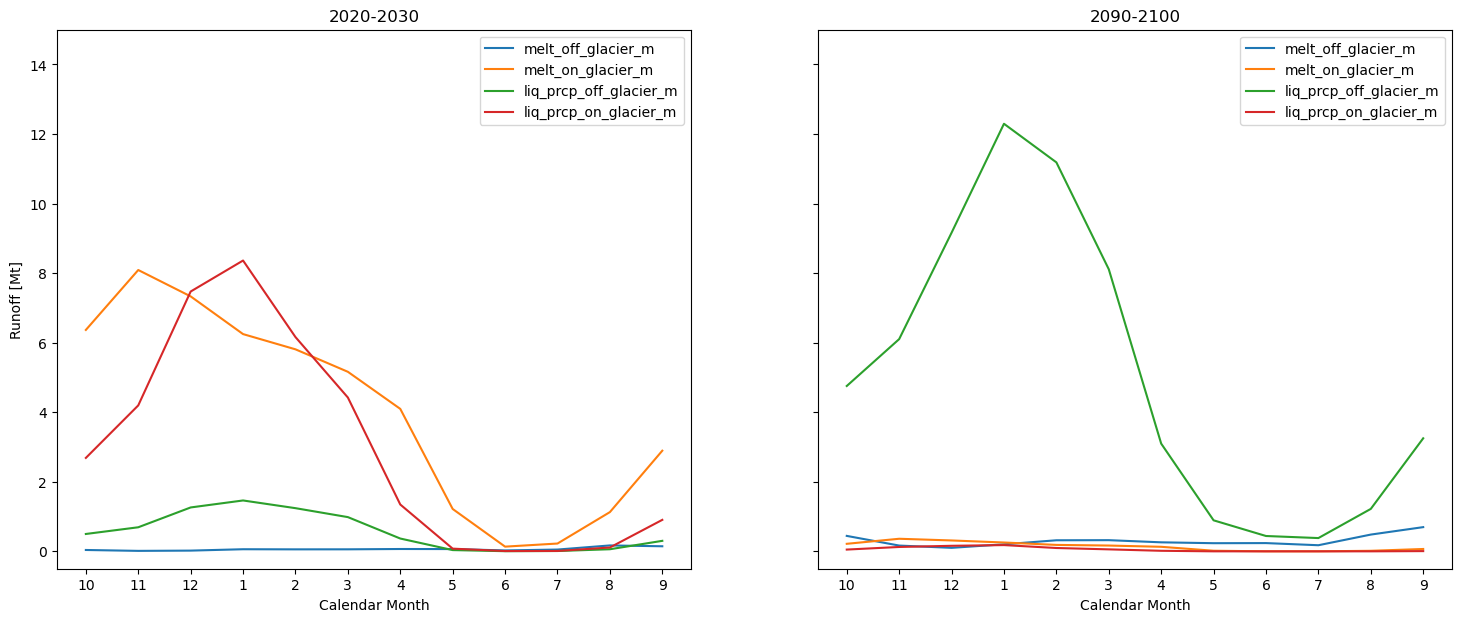

In [60]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s126.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s126, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e126, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

plt.ylim([-0.5,15]);

Why do the graphs above start at month 10? They do in Molly's notebook as well (come back to this)

# Calculate ssp370

In [35]:
# Make a dictionary with all data for all GCMs (this will only output one ssp!)
ssp_monthly_dict370 = {}

x=0
ssp = 'ssp370'

# Per ssp:
for ssp in ssp_list:
    ssp_value = open_series(fpath_stem=base, which_date='2024-06-12', which_gcm=gcm, which_ssp=ssp)
    k = '{}-{}'.format(gcm, ssp)
    ssp_monthly_dict370[k]=ssp_value
    x += 1

In [36]:
ssp_monthly_dict370['mri-esm2-0_r1i1p1f1-ssp370']

<xarray.Dataset> Size: 1MB
Dimensions:                       (time: 82, rgi_id: 35, month_2d: 12)
Coordinates:
  * time                          (time) float64 656B 2.02e+03 ... 2.101e+03
  * rgi_id                        (rgi_id) <U14 2kB 'RGI60-16.00495' ... 'RGI...
    hydro_year                    (time) int64 656B ...
    hydro_month                   (time) int64 656B ...
    calendar_year                 (time) int64 656B ...
    calendar_month                (time) int64 656B ...
  * month_2d                      (month_2d) int64 96B 1 2 3 4 5 ... 9 10 11 12
    calendar_month_2d             (month_2d) int64 96B ...
Data variables: (12/24)
    volume                        (time, rgi_id) float32 11kB ...
    volume_bsl                    (time, rgi_id) float32 11kB ...
    volume_bwl                    (time, rgi_id) float32 11kB ...
    area                          (time, rgi_id) float32 11kB ...
    length                        (time, rgi_id) float32 11kB ...
    calving                       (time, rgi_id) float32 11kB ...
    ...                            ...
    liq_prcp_on_glacier_monthly   (time, month_2d, rgi_id) float32 138kB ...
    snowfall_off_glacier_monthly  (time, month_2d, rgi_id) float32 138kB ...
    snowfall_on_glacier_monthly   (time, month_2d, rgi_id) float32 138kB ...
    water_level                   (rgi_id) float32 140B ...
    glen_a                        (rgi_id) float32 140B ...
    fs                            (rgi_id) float32 140B ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.1
    calendar:       365-day no leap
    creation_date:  2024-06-12 18:07:19

In [37]:
# Bring in your dictionary of unrolled values to find TOTAL RUNOFF (for time slice plot)
season_unroll370 = {}
for k in ssp_monthly_dict370.keys():
    calculation = calc_seasonal(ssp_monthly_dict370[k])
    z = '{}-calc'.format(k)
    season_unroll370[z] = calculation

In [38]:
# make current gcm
season_unroll370['mri-esm2-0_r1i1p1f1-ssp370-calc']

<xarray.DataArray (time: 81, month_2d: 12)> Size: 4kB
array([[1.81042843e+01, 1.10777712e+01, 1.12644949e+01, 4.07563066e+00,
        9.26627100e-01, 1.64935648e-01, 1.92261830e-01, 1.17616808e+00,
        2.14819884e+00, 1.02975569e+01, 1.60372791e+01, 1.27906618e+01],
       [1.13057079e+01, 1.26881275e+01, 8.98024940e+00, 3.35479236e+00,
        1.45131576e+00, 1.25511318e-01, 6.21094815e-02, 1.30099940e+00,
        2.59198761e+00, 1.10134401e+01, 1.37133045e+01, 1.78078804e+01],
       [1.80525513e+01, 1.41695108e+01, 1.42615986e+01, 8.31426620e+00,
        2.67343497e+00, 1.44334003e-01, 7.09564447e-01, 4.59869242e+00,
        6.64586735e+00, 1.17776775e+01, 1.39265070e+01, 1.98579121e+01],
       [1.75124302e+01, 1.46207657e+01, 1.11231403e+01, 8.83371449e+00,
        2.33418226e+00, 3.97331119e-01, 3.74416679e-01, 1.40271747e+00,
        3.92043519e+00, 1.01257315e+01, 1.10536995e+01, 1.51865740e+01],
       [1.81668987e+01, 1.74112988e+01, 1.25065241e+01, 3.42187119e+00,
        1.06554925e+00, 4.64849658e-02, 2.97588166e-02, 2.14303708e+00,
        3.22501111e+00, 1.08225985e+01, 1.32955704e+01, 1.69119167e+01],
       [1.94186401e+01, 1.20424261e+01, 8.37112045e+00, 5.08378696e+00,
        5.40201783e-01, 6.84314668e-02, 9.34058353e-02, 8.90316546e-01,
        5.37537813e+00, 1.22124414e+01, 1.39540253e+01, 1.52350903e+01],
       [1.60553722e+01, 1.63856583e+01, 1.48877611e+01, 6.68779278e+00,
        1.80623567e+00, 2.98228592e-01, 7.82017887e-01, 5.81014693e-01,
...
        3.56817818e+00, 2.47372603e+00, 7.26887226e+00, 7.83520651e+00],
       [1.19120121e+01, 7.48733997e+00, 3.60049200e+00, 5.81662369e+00,
        4.18737352e-01, 1.07617378e+00, 2.05757201e-01, 1.03122771e+00,
        2.94952154e+00, 2.36857009e+00, 7.98460865e+00, 9.29414845e+00],
       [1.33377895e+01, 1.26245842e+01, 1.00738449e+01, 2.38441920e+00,
        1.53457955e-01, 7.90120363e-01, 2.00793460e-01, 2.98338628e+00,
        2.98030424e+00, 4.01454163e+00, 5.42279148e+00, 5.95726919e+00],
       [9.87504005e+00, 7.62079096e+00, 6.35121918e+00, 4.77591801e+00,
        2.01022308e-02, 8.78785789e-01, 8.11098456e-01, 5.62676132e-01,
        5.31001949e+00, 2.38284779e+00, 4.88243628e+00, 1.51579351e+01],
       [1.40761566e+01, 1.21014967e+01, 5.41363192e+00, 2.50423551e+00,
        8.41028914e-02, 1.88366428e-01, 3.16150457e-01, 2.99830842e+00,
        3.77738976e+00, 8.69627953e+00, 4.02371740e+00, 9.91912746e+00],
       [1.26958742e+01, 1.25805759e+01, 7.40994215e+00, 3.28975368e+00,
        4.11751890e+00, 7.66306043e-01, 3.62216592e+00, 1.48170769e+00,
        4.09090996e+00, 7.42288113e+00, 5.18988037e+00, 8.64434719e+00],
       [1.00918226e+01, 1.25274000e+01, 4.97457314e+00, 1.31054628e+00,
        1.18457332e-01, 1.44810104e+00, 5.61228156e-01, 9.46741462e-01,
        4.39161682e+00, 5.71016169e+00, 8.88320732e+00, 7.97622156e+00]],
      dtype=float32)
Coordinates:
  * time               (time) float64 648B 2.02e+03 2.021e+03 ... 2.1e+03
    hydro_year         (time) int64 648B 2020 2021 2022 2023 ... 2098 2099 2100
    hydro_month        (time) int64 648B 10 10 10 10 10 10 ... 10 10 10 10 10 10
    calendar_year      (time) int64 648B 2020 2021 2022 2023 ... 2098 2099 2100
    calendar_month     (time) int64 648B 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
  * month_2d           (month_2d) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d  (month_2d) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [39]:
# define keys to use in next step
keys370 = season_unroll370.keys()

In [40]:
# Roll coordinates!
dict_roll370 = {}
dict_plot370 = {}

for k in keys370:
    season_roll = season_unroll370[k].roll(month_2d=n_roll, roll_coords=False) # this has to be false
    season_forplot = season_unroll370[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll370[name] = season_roll
    dict_plot370[name] = season_forplot

In [41]:
# Roll and sum
rtype_roll370 = {}

for k in ssp_monthly_dict370.keys():
    rtype_season = ssp_monthly_dict370[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll370[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [42]:
rtype_roll370.keys()

dict_keys(['mri-esm2-0_r1i1p1f1-ssp126', 'mri-esm2-0_r1i1p1f1-ssp370', 'mri-esm2-0_r1i1p1f1-ssp585'])

In [43]:
rtype_calc_s370 = {}
rtype_calc_e370 = {}

for k in rtype_roll370.keys():
    df_key = rtype_roll370[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s370[calc_name] = df_m_s

for k in rtype_roll370.keys():
    df_key = rtype_roll370[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e370[calc_name] = df_m_e

In [44]:
season_roll2 = season_unroll370['mri-esm2-0_r1i1p1f1-ssp370-calc'].roll(month_2d=n_roll, roll_coords=True)

In [45]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll370['mri-esm2-0_r1i1p1f1-ssp370-calc']
index2 = index1['month_2d']

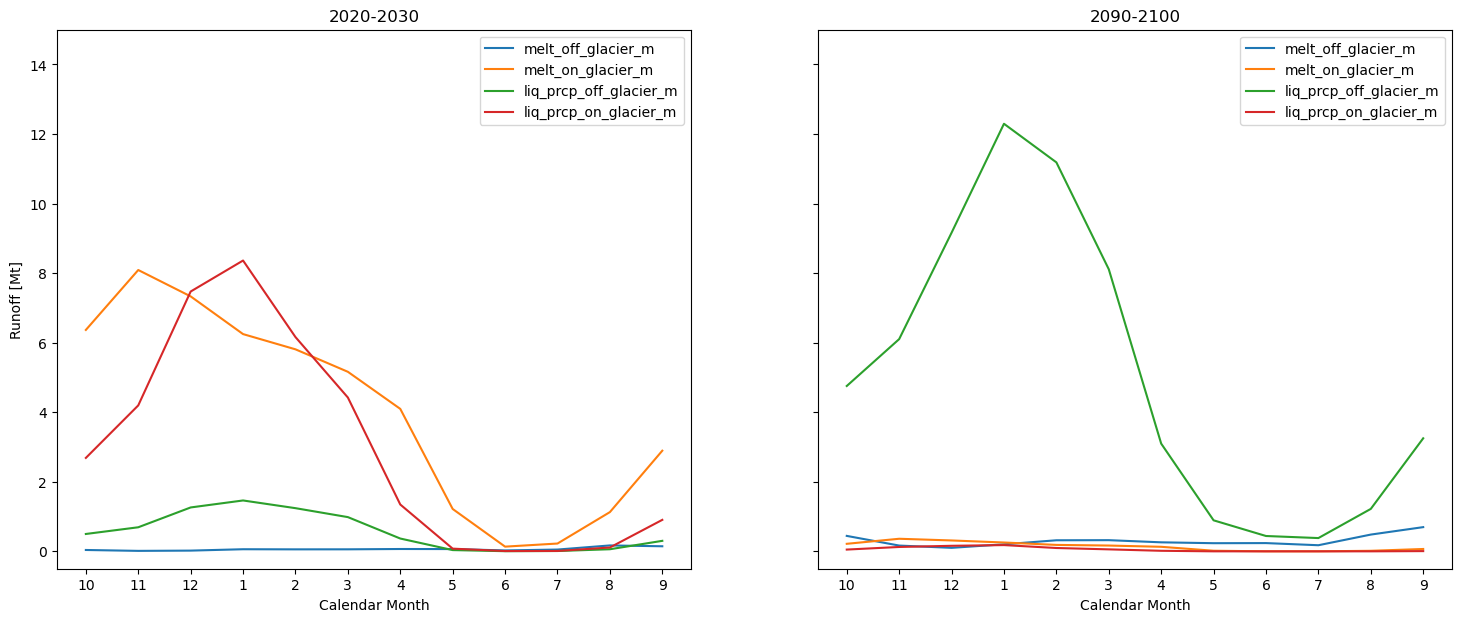

In [47]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s370.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s370, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e370, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

plt.ylim([-0.5,15]);

# Calculate ssp585

In [48]:
# Make a dictionary with all data for all GCMs (this will only output one ssp!)
ssp_monthly_dict585 = {}

x=0
ssp = 'ssp585'

# Per ssp:
for ssp in ssp_list:
    ssp_value = open_series(fpath_stem=base, which_date='2024-06-12', which_gcm=gcm, which_ssp=ssp)
    k = '{}-{}'.format(gcm, ssp)
    ssp_monthly_dict585[k]=ssp_value
    x += 1

In [49]:
ssp_monthly_dict585['mri-esm2-0_r1i1p1f1-ssp585']

<xarray.Dataset> Size: 1MB
Dimensions:                       (time: 82, rgi_id: 35, month_2d: 12)
Coordinates:
  * time                          (time) float64 656B 2.02e+03 ... 2.101e+03
  * rgi_id                        (rgi_id) <U14 2kB 'RGI60-16.00495' ... 'RGI...
    hydro_year                    (time) int64 656B ...
    hydro_month                   (time) int64 656B ...
    calendar_year                 (time) int64 656B ...
    calendar_month                (time) int64 656B ...
  * month_2d                      (month_2d) int64 96B 1 2 3 4 5 ... 9 10 11 12
    calendar_month_2d             (month_2d) int64 96B ...
Data variables: (12/24)
    volume                        (time, rgi_id) float32 11kB ...
    volume_bsl                    (time, rgi_id) float32 11kB ...
    volume_bwl                    (time, rgi_id) float32 11kB ...
    area                          (time, rgi_id) float32 11kB ...
    length                        (time, rgi_id) float32 11kB ...
    calving                       (time, rgi_id) float32 11kB ...
    ...                            ...
    liq_prcp_on_glacier_monthly   (time, month_2d, rgi_id) float32 138kB ...
    snowfall_off_glacier_monthly  (time, month_2d, rgi_id) float32 138kB ...
    snowfall_on_glacier_monthly   (time, month_2d, rgi_id) float32 138kB ...
    water_level                   (rgi_id) float32 140B ...
    glen_a                        (rgi_id) float32 140B ...
    fs                            (rgi_id) float32 140B ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.1
    calendar:       365-day no leap
    creation_date:  2024-06-12 18:07:20

In [50]:
# Bring in your dictionary of unrolled values to find TOTAL RUNOFF (for time slice plot)
season_unroll585 = {}
for k in ssp_monthly_dict585.keys():
    calculation = calc_seasonal(ssp_monthly_dict585[k])
    z = '{}-calc'.format(k)
    season_unroll585[z] = calculation

In [51]:
# make current gcm

season_unroll585['mri-esm2-0_r1i1p1f1-ssp585-calc']

<xarray.DataArray (time: 81, month_2d: 12)> Size: 4kB
array([[1.55466499e+01, 8.44933033e+00, 6.96547318e+00, 5.11459589e+00,
        3.21941209e+00, 3.96349281e-01, 2.85634607e-01, 3.98854911e-01,
        3.46749496e+00, 1.07397947e+01, 1.29862566e+01, 1.56100903e+01],
       [1.31343699e+01, 1.52024345e+01, 8.63222599e+00, 6.00136709e+00,
        6.95582688e-01, 7.84362182e-02, 2.17240825e-01, 1.93796074e+00,
        3.04281974e+00, 8.99065018e+00, 1.58034716e+01, 1.74411201e+01],
       [1.51772051e+01, 8.26384354e+00, 9.21459484e+00, 4.13913822e+00,
        1.12615681e+00, 7.12917745e-02, 4.90508944e-01, 7.06329882e-01,
        1.57197845e+00, 7.31882238e+00, 1.31018248e+01, 1.79105759e+01],
       [1.72871418e+01, 1.17580547e+01, 1.09583750e+01, 6.30599976e+00,
        7.19701231e-01, 3.90614897e-01, 9.79318991e-02, 6.94790423e-01,
        2.98172712e+00, 5.63736391e+00, 1.24502640e+01, 1.78499279e+01],
       [1.84909172e+01, 1.15780859e+01, 1.35200748e+01, 6.38113546e+00,
        5.44773698e-01, 2.64731199e-01, 4.30248380e-01, 3.71872234e+00,
        3.87288737e+00, 1.25093861e+01, 1.65640297e+01, 1.82685032e+01],
       [2.07753963e+01, 1.69337006e+01, 1.21536484e+01, 5.80828047e+00,
        1.24672723e+00, 7.87617117e-02, 2.14418888e-01, 1.03558183e+00,
        5.03918839e+00, 9.67985344e+00, 1.36114826e+01, 1.86754379e+01],
       [1.95474129e+01, 1.77177906e+01, 8.17494678e+00, 5.95897007e+00,
        1.07626808e+00, 1.95946112e-01, 1.27400160e-01, 7.64181674e-01,
...
        5.44244051e+00, 7.78725767e+00, 9.00265026e+00, 1.57846975e+01],
       [1.43525476e+01, 1.64410248e+01, 8.72532272e+00, 4.06334162e+00,
        6.72544813e+00, 5.49243867e-01, 5.96769527e-02, 1.28689730e+00,
        2.35576248e+00, 1.08305683e+01, 8.91854000e+00, 1.38550739e+01],
       [8.88966179e+00, 8.81451702e+00, 1.72725410e+01, 2.97892499e+00,
        1.17501188e-02, 1.31997311e+00, 1.36666551e-01, 7.38551080e-01,
        1.81104887e+00, 4.43820238e+00, 3.05364776e+00, 9.95989132e+00],
       [1.34301710e+01, 8.56295109e+00, 9.99907398e+00, 5.36110830e+00,
        1.80555105e-01, 1.74305767e-01, 2.68155664e-01, 2.31328440e+00,
        3.54678392e+00, 3.59559155e+00, 2.86985970e+00, 1.23959885e+01],
       [2.02610435e+01, 1.70612965e+01, 6.16991997e+00, 4.11746788e+00,
        3.05390739e+00, 2.32762814e-01, 4.49101580e-03, 1.47467697e+00,
        1.93948376e+00, 1.02103443e+01, 7.86400509e+00, 1.10075121e+01],
       [9.24875164e+00, 1.18026276e+01, 1.30518961e+01, 3.50530720e+00,
        1.48558617e+00, 6.99671149e-01, 2.58256078e-01, 1.53230858e+00,
        4.91746092e+00, 5.71218252e+00, 5.73833227e+00, 5.81133556e+00],
       [1.21136398e+01, 9.84279346e+00, 1.09049063e+01, 5.52039385e+00,
        2.89206654e-01, 2.23048830e+00, 1.32439435e+00, 1.19143248e-01,
        3.89849234e+00, 1.70604849e+00, 3.53301740e+00, 5.48279762e+00]],
      dtype=float32)
Coordinates:
  * time               (time) float64 648B 2.02e+03 2.021e+03 ... 2.1e+03
    hydro_year         (time) int64 648B 2020 2021 2022 2023 ... 2098 2099 2100
    hydro_month        (time) int64 648B 10 10 10 10 10 10 ... 10 10 10 10 10 10
    calendar_year      (time) int64 648B 2020 2021 2022 2023 ... 2098 2099 2100
    calendar_month     (time) int64 648B 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
  * month_2d           (month_2d) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d  (month_2d) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [52]:
# define keys to use in next step
keys585 = season_unroll585.keys()

In [53]:
# Roll coordinates!
dict_roll585 = {}
dict_plot585 = {}

for k in keys585:
    season_roll = season_unroll585[k].roll(month_2d=n_roll, roll_coords=False) # this has to be false
    season_forplot = season_unroll585[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll585[name] = season_roll
    dict_plot585[name] = season_forplot

In [54]:
# Roll and sum
rtype_roll585 = {}

for k in ssp_monthly_dict585.keys():
    rtype_season = ssp_monthly_dict585[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll585[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [55]:
rtype_roll585.keys()

dict_keys(['mri-esm2-0_r1i1p1f1-ssp126', 'mri-esm2-0_r1i1p1f1-ssp370', 'mri-esm2-0_r1i1p1f1-ssp585'])

In [56]:
rtype_calc_s585 = {}
rtype_calc_e585 = {}

for k in rtype_roll585.keys():
    df_key = rtype_roll585[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s585[calc_name] = df_m_s

for k in rtype_roll585.keys():
    df_key = rtype_roll585[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e585[calc_name] = df_m_e

In [57]:
season_roll2 = season_unroll585['mri-esm2-0_r1i1p1f1-ssp585-calc'].roll(month_2d=n_roll, roll_coords=True)

In [58]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll585['mri-esm2-0_r1i1p1f1-ssp585-calc']
index2 = index1['month_2d']

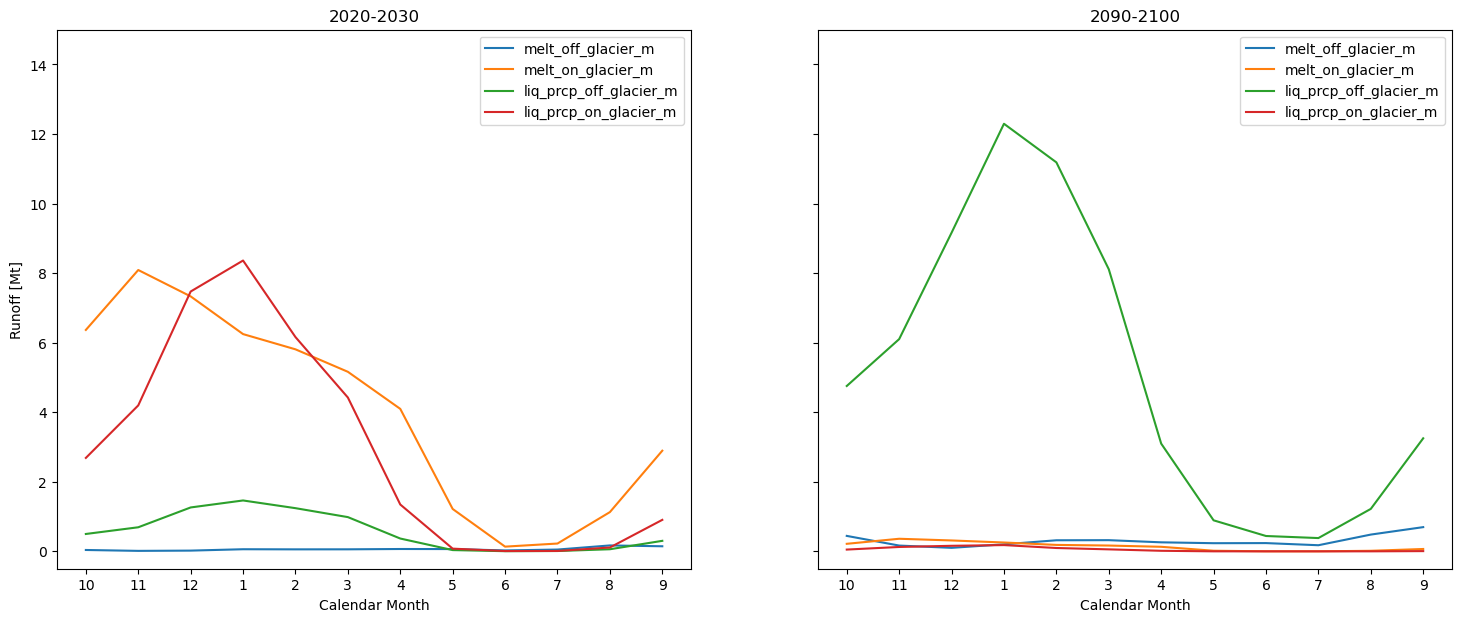

In [59]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s585.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s585, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e585, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

plt.ylim([-0.5,15]);

In [ ]:
key_dict = {}

key_dict['sup26'] = season_unroll26.keys()
key_dict['sup45'] = season_unroll45.keys()
key_dict['sup60'] = season_unroll60.keys()
key_dict['sup85'] = season_unroll85.keys()

In [ ]:
# Let's try to get this to show each GCM as well as means!
time = [0, 20, 40, 80]

color_ts = ('#cce0f4', '#7bafe3', '#2b7ed1', '#2365a8')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 8), sharey=True, constrained_layout = True)

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['ssp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax1.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['ssp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax2.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['ssp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax3.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1
    
t_idx=0
for t in time:
    season_t = season_sliced(key_dict['ssp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax4.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

ax1.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'ssp 2.6',
        ylabel = 'Runoff [Mt]');
ax2.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'ssp 4.5');
ax3.set(xticks = season_roll['month_2d'].values,
        ylabel = 'Runoff [Mt]',
        xticklabels = season_roll2['month_2d'].values,
        title = 'ssp 6.0',
        xlabel = 'Month');
ax4.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'ssp 8.5',
        xlabel = 'Month');
ax1.legend();

plt.ssptitle('Multi-GCM mean seasonal runoff for four selected years', fontweight = 'bold', fontsize = 14);

## Visualize time slices!

In [61]:
key_dict = {}

key_dict['ssp126'] = season_unroll126.keys()
key_dict['ssp370'] = season_unroll370.keys()
key_dict['ssp585'] = season_unroll585.keys()

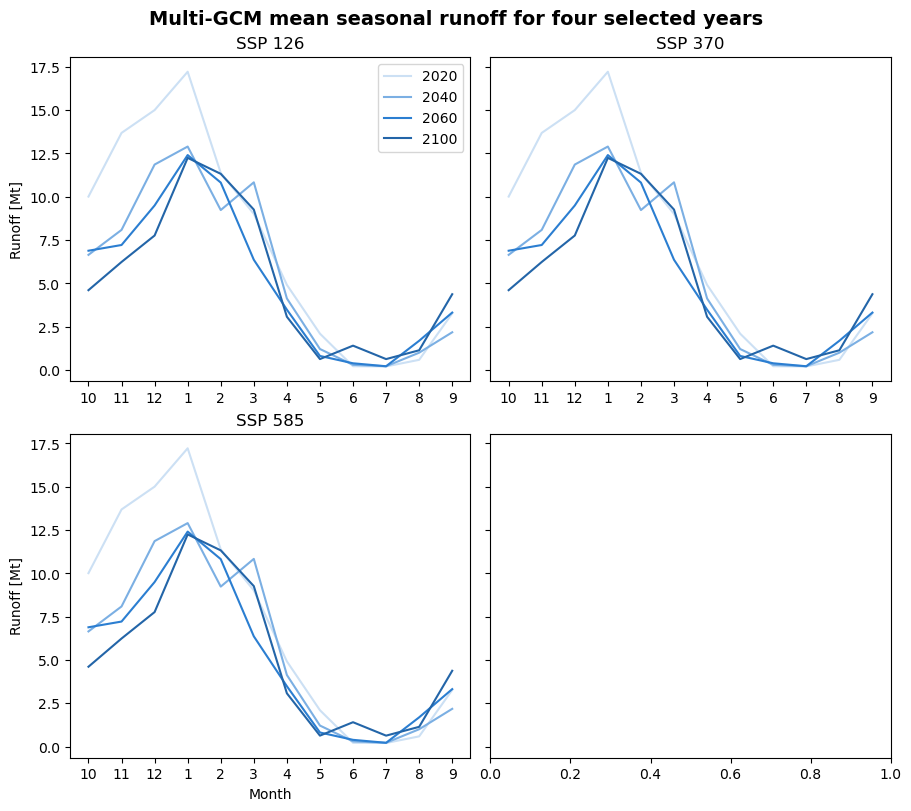

In [62]:
# Let's try to get this to show each GCM as well as means!
time = [0, 20, 40, 80]

color_ts = ('#cce0f4', '#7bafe3', '#2b7ed1', '#2365a8')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 8), sharey=True, constrained_layout = True)

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['ssp126'], dict_roll126, t)
    xvals = np.asarray(season_t.index)+1
    ax1.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['ssp370'], dict_roll370, t)
    xvals = np.asarray(season_t.index)+1
    ax2.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['ssp585'], dict_roll585, t)
    xvals = np.asarray(season_t.index)+1
    ax3.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

ax1.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'SSP 126',
        ylabel = 'Runoff [Mt]');
ax2.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'SSP 370');
ax3.set(xticks = season_roll['month_2d'].values,
        ylabel = 'Runoff [Mt]',
        xticklabels = season_roll2['month_2d'].values,
        title = 'SSP 585',
        xlabel = 'Month');
ax1.legend();

plt.suptitle('Multi-GCM mean seasonal runoff for four selected years', fontweight = 'bold', fontsize = 14);

This figure is wrong; the data is 7 months offset

## Compiled decadal runoff by ssp

I want to figure out how to add a legend to these plots.

In [ ]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(7, 10), sharey=True, constrained_layout=True)

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

s_keys = rtype_calc_s26.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s26, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e26, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax2.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s26, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e26, sum_vars[0], sum_vars[1])
xvals = index2
ax1.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax2.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s45.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s45, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e45, r)
    xvals = index2
    ax3.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax4.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s45, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e45, sum_vars[0], sum_vars[1])
xvals = index2
ax3.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax4.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s60.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s60, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e60, r)
    xvals = index2
    ax5.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax6.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s60, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e60, sum_vars[0], sum_vars[1])
xvals = index2
ax5.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax6.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s85.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s85, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e85, r)
    xvals = index2
    ax7.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax8.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s85, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e85, sum_vars[0], sum_vars[1])
xvals = index2
ax7.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax8.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

ax1.set(ylabel='Runoff [Mt]', title='2020-2030') # this title and the next one are overwritten by my addition
ax2.set(title='2090-2100')
ax3.set(ylabel='Runoff [Mt]')
ax5.set(ylabel='Runoff [Mt]')
ax7.set(ylabel='Runoff [Mt]', xlabel='Month')
ax8.set(xlabel='Month')

# THIS WORKS
for ax in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8):
    ax.set(xticks=season_roll['month_2d'].values,
           xticklabels=season_roll2['month_2d'].values,  # here, we want calendar year values
           )

ax1.text(0.03, 0.9, 'ssp 2.6', transform=ax1.transAxes)
ax2.text(0.03, 0.9, 'ssp 2.6', transform=ax2.transAxes)
ax3.text(0.03, 0.9, 'ssp 4.5', transform=ax3.transAxes)
ax4.text(0.03, 0.9, 'ssp 4.5', transform=ax4.transAxes)
ax5.text(0.03, 0.9, 'ssp 6.0', transform=ax5.transAxes)
ax6.text(0.03, 0.9, 'ssp 6.0', transform=ax6.transAxes)
ax7.text(0.03, 0.9, 'ssp 8.5', transform=ax7.transAxes)
ax8.text(0.03, 0.9, 'ssp 8.5', transform=ax8.transAxes)

plt.ssptitle('Decadal seasonal runoff averages by runoff component', fontweight='bold', fontsize=14)

plt.show()


In [ ]:
# this code is from ChatGPT

import matplotlib.pyplot as plt

# Define the runoff variables and colors
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
color_pr = '#946cbd'
color_m = ['#d9985f', '#d16b6c']

# Create subplots with shared y-axis
fig, axes = plt.subplots(4, 2, figsize=(8, 10.5), sharey=True)
(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8) = axes

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# Plotting function to avoid repetition
def plot_runoff(ax, rtype_calc_s, rtype_calc_e, s_keys, rtype_label):
    ct = 0
    for r in runoff_variables:
        runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, r)
        runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, r)
        xvals = index2
        ax[0].plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
        ax[1].plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
        ct += 1
    runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s, sum_vars[0], sum_vars[1])
    runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e, sum_vars[0], sum_vars[1])
    ax[0].plot(xvals, runoff_s['mean'], label='Total liquid precipitation', color=color_pr)
    ax[1].plot(xvals, runoff_e['mean'], label='Total liquid precipitation', color=color_pr)
    ax[0].set(ylabel='Runoff [Mt]')
    ax[0].text(0.03, 0.9, rtype_label, transform=ax[0].transAxes)
    ax[1].text(0.03, 0.9, rtype_label, transform=ax[1].transAxes)

# Plot each ssp scenario
plot_runoff([ax1, ax2], rtype_calc_s26, rtype_calc_e26, rtype_calc_s26.keys(), 'ssp 2.6')
plot_runoff([ax3, ax4], rtype_calc_s45, rtype_calc_e45, rtype_calc_s45.keys(), 'ssp 4.5')
plot_runoff([ax5, ax6], rtype_calc_s60, rtype_calc_e60, rtype_calc_s60.keys(), 'ssp 6.0')
plot_runoff([ax7, ax8], rtype_calc_s85, rtype_calc_e85, rtype_calc_s85.keys(), 'ssp 8.5')

# Set titles for the columns
ax1.set(title='2020-2030')
ax2.set(title='2090-2100')

# Set x-axis labels and ticks
for ax in (ax7, ax8):
    ax.set(xlabel='Month')
for ax in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8):
    ax.set(xticks=season_roll['month_2d'].values, xticklabels=season_roll2['month_2d'].values)

# Add a single legend to the right of the plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.19, 0.84), borderaxespad=0.)

# Add a ssper title with adjusted vertical position
fig.ssptitle('Decadal seasonal runoff averages by runoff component', fontweight='bold', fontsize=14, y=0.94)

plt.show()

### Plot of relative contribution on decade scale

In [ ]:
# Set up the dictionaries with values to use in the summing function
s_keys_dict = {}
s_keys_dict['ssp26'] = rtype_calc_s26.keys()
s_keys_dict['ssp45'] = rtype_calc_s45.keys()
s_keys_dict['ssp60'] = rtype_calc_s60.keys()
s_keys_dict['ssp85'] = rtype_calc_s85.keys()

rtype_calc_dict_s = {}
rtype_calc_dict_s['ssp26'] = rtype_calc_s26
rtype_calc_dict_s['ssp45'] = rtype_calc_s45
rtype_calc_dict_s['ssp60'] = rtype_calc_s60
rtype_calc_dict_s['ssp85'] = rtype_calc_s85

rtype_calc_dict_e = {}
rtype_calc_dict_e['ssp26'] = rtype_calc_e26
rtype_calc_dict_e['ssp45'] = rtype_calc_e45
rtype_calc_dict_e['ssp60'] = rtype_calc_e60
rtype_calc_dict_e['ssp85'] = rtype_calc_e85

In [ ]:
ssp = ('ssp26', 'ssp45', 'ssp60', 'ssp85')

all_ssp_dict_s = {}

for r in ssp:
    melt_on = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_s[r], 'melt_on_glacier_m')
    melt_off = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_s[r], 'melt_off_glacier_m')
    liq = rtype_calc_monthly_2vars(s_keys_dict[r], rtype_calc_dict_s[r], 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m')
    summed = melt_on + melt_off + liq
    m_on_name = 'm-on-{}'.format(r)
    m_off_name = 'm-off-{}'.format(r)
    liq_name = 'liq-{}'.format(r)
    sum_name = 'sum-{}'.format(r)
    all_ssp_dict_s[m_on_name] = melt_on
    all_ssp_dict_s[m_off_name] = melt_off
    all_ssp_dict_s[liq_name] = liq
    all_ssp_dict_s[sum_name] = summed

all_ssp_dict_e = {}

for r in ssp:
    melt_on = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_e[r], 'melt_on_glacier_m')
    melt_off = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_e[r], 'melt_off_glacier_m')
    liq = rtype_calc_monthly_2vars(s_keys_dict[r], rtype_calc_dict_e[r], 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m')
    summed = melt_on + melt_off + liq
    m_on_name = 'm-on-{}'.format(r)
    m_off_name = 'm-off-{}'.format(r)
    liq_name = 'liq-{}'.format(r)
    sum_name = 'sum-{}'.format(r)
    all_ssp_dict_e[m_on_name] = melt_on
    all_ssp_dict_e[m_off_name] = melt_off
    all_ssp_dict_e[liq_name] = liq
    all_ssp_dict_e[sum_name] = summed

In [ ]:
# Graph of relative importance of runoff for each part of the seasonal cycle (decade 1 and last)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(9, 11), sharey=True, constrained_layout = True);

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

xvals = index2

# ssp 2.6
ssp_key = 'ssp26'
ax1.stackplot(xvals, all_ssp_dict_s['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_s['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_s['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax2.stackplot(xvals, all_ssp_dict_e['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_e['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_e['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# ssp4.5
ssp_key = 'ssp45'
ax3.stackplot(xvals, all_ssp_dict_s['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_s['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_s['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax4.stackplot(xvals, all_ssp_dict_e['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_e['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_e['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# ssp6.0
ssp_key = 'ssp60'
ax5.stackplot(xvals, all_ssp_dict_s['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_s['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_s['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax6.stackplot(xvals, all_ssp_dict_e['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_e['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_e['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# ssp85
ssp_key = 'ssp85'
ax7.stackplot(xvals, all_ssp_dict_s['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_s['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_s['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax8.stackplot(xvals, all_ssp_dict_e['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_e['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_e['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

#ax1.legend(bbox_to_anchor=(0.44, 0.95));

plt.ssptitle('Relative seasonal contribution of runoff components', fontweight = 'bold', fontsize = 14);

ax1.set(ylabel='% Total runoff', title='2020-2030')
ax2.set(title='2090-2100')
ax3.set(ylabel='% Total runoff')
ax5.set(ylabel='% Total runoff')
ax7.set(ylabel='% Total runoff', xlabel = 'Month')
ax8.set(xlabel = 'Month')
# THIS WORKS
for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values #here, we want calendar year values
          );
# Add ssp labels as titles (from chatgpt)
ax1.set_title('ssp 2.6: 2020-2030', fontsize=10)
ax2.set_title('ssp 2.6: 2090-2100', fontsize=10)
ax3.set_title('ssp 4.5: 2020-2030', fontsize=10)
ax4.set_title('ssp 4.5: 2090-2100', fontsize=10)
ax5.set_title('ssp 6.0: 2020-2030', fontsize=10)
ax6.set_title('ssp 6.0: 2090-2100', fontsize=10)
ax7.set_title('ssp 8.5: 2020-2030', fontsize=10)
ax8.set_title('ssp 8.5: 2090-2100', fontsize=10)

#plt.savefig('Figures/Seasonal/Decade_av/4x2_relative_importance_newMay4.png', bbox_inches='tight')

# Step 2: try with another GCM

In [ ]:
# This is place to add GCMs and dates; it only needs to be in one place, so I commented it out

# # Define variables that will be used for each test
# base = '/Users/ziggygoddard/Documents/summer24/'

# gcm_list = ['NorESM1-M', 'CCSM4'] # just the current gcm

# date_list = ['2024-06-05', '2024-06-06'] # export date (date I downloaded the data)

# ssp_list = ['ssp26', 'ssp45', 'ssp60', 'ssp85'] # this stays the same

# gcm_w60 = ['NorESM1-M', 'CCSM4'] 

# all_monthly_dict = {}

# # These have to be files that I have downloaded

## Try to make a mega-dictionary with all ssps

In [ ]:
# create dictionary
all_monthly_dict = {}

In [ ]:
ssp_monthly_dict = {}

for ssp in ssp_list:
    ssp_dict = {}
    for i, gcm in enumerate(gcm_list):
        date = date_list[i]  # Ensure the date corresponds to the correct GCM
        filepath = f"{base}{date}-gcm_data_{gcm}_{ssp}_compiled_output.nc"
        print(f"Trying to open file: {filepath}")
        if ssp != 'ssp60':
            ssp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_ssp=ssp)
            k = '{}-{}'.format(gcm, ssp)
            ssp_dict[k] = ssp_value
        else:
            if gcm in gcm_w60:
                ssp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_ssp=ssp)
                k = '{}-{}'.format(gcm, ssp)
                ssp_dict[k] = ssp_value
    ssp_monthly_dict[ssp] = ssp_dict

In [ ]:
x=0
ssp = ['ssp26', 'ssp45', 'ssp60', 'ssp85']

for r in ssp:
    x = 0
    for gcm in gcm_list:
        if r != 'ssp60':
            ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=r)
            k = '{}-{}'.format(gcm, r)
            all_monthly_dict[k] = ssp_value
        else:
            if gcm in gcm_w60:
                ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=r)
                k = '{}-{}'.format(gcm, r)
                all_monthly_dict[k]=ssp_value
        x += 1

In [ ]:
# Define keys
keys_all = all_monthly_dict.keys()

In [ ]:
all_unrolled = {}
for k in keys_all:
    calculation = calc_seasonal(all_monthly_dict[k])
    z = '{}'.format(k)
    all_unrolled[z] = calculation

Roll values for plotting

In [ ]:
n_roll = 3

dict_roll_all = {}
dict_plot_all = {}

for k in keys_all:
    season_roll = all_unrolled[k].roll(month_2d=n_roll, roll_coords=True)
    season_forplot = all_unrolled[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll_all[name] = season_roll
    dict_plot_all[name] = season_forplot

In [ ]:
dict_roll_all

Take sum over rgi id

In [ ]:
rtype_all = {}

for k in keys_all:
    rtype_season = all_monthly_dict[k].roll(roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_all[rtype_name] = rtype_sum

In [ ]:
# Make a dictionary with all data for all GCMs for each ssp
ssp_monthly_dict = {}

for ssp in ssp_list:
    ssp_dict = {}
    for gcm in gcm_list:
        for date in date_list:
            # Check if the ssp is not 'ssp60' or the GCM is in gcm_w60
            if ssp != 'ssp60' or gcm in gcm_w60:
                filepath = base + '{}-gcm_data_{}_{}_compiled_output.nc'.format(date, gcm, ssp)
                # Check if the file exists before attempting to open it
                if os.path.exists(filepath):
                    ssp_value = open_series(fpath_stem=base, which_date=date, which_gcm=gcm, which_ssp=ssp)
                    k = '{}-{}'.format(gcm, ssp)
                    ssp_dict[k] = ssp_value
    ssp_monthly_dict[ssp] = ssp_dict

### Calculate ssp26

In [ ]:
# Make a dictionary with all data for all GCMs (this will only output one ssp!)
ssp_monthly_dict26 = {}

x=0
ssp = 'ssp26'

# Per ssp:
for gcm in gcm_list:
    if ssp != 'ssp60':
        ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=ssp)
        k = '{}-{}'.format(gcm, ssp)
        ssp_monthly_dict26[k]=ssp_value
    else:
        if gcm in gcm_w60:
            ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=ssp)
            k = '{}-{}'.format(gcm, ssp)
            ssp_monthly_dict26[k]=ssp_value
    x += 1

In [ ]:
ssp_monthly_dict26['CCSM4-ssp26']

In [ ]:
# Bring in your dictionary of unrolled values to find TOTAL RUNOFF (for time slice plot)
season_unroll26 = {}
for k in ssp_monthly_dict26.keys():
    calculation = calc_seasonal(ssp_monthly_dict26[k])
    z = '{}-calc'.format(k)
    season_unroll26[z] = calculation

In [ ]:
# make current gcm

season_unroll26['CCSM4-ssp26-calc']

In [ ]:
# define keys to use in next step
keys26 = season_unroll26.keys()

In [ ]:
# Roll coordinates!
dict_roll26 = {}
dict_plot26 = {}

for k in keys26:
    season_roll = season_unroll26[k].roll(month_2d=n_roll, roll_coords=False)
    season_forplot = season_unroll26[k].roll(month_2d=n_roll, roll_coords=False) 
    name = '{}'.format(k)
    dict_roll26[name] = season_roll
    dict_plot26[name] = season_forplot

In [ ]:
# Roll and sum
rtype_roll26 = {}

for k in ssp_monthly_dict26.keys():
    rtype_season = ssp_monthly_dict26[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll26[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [ ]:
rtype_roll26.keys()

In [ ]:
rtype_calc_s26 = {}
rtype_calc_e26 = {}

for k in rtype_roll26.keys():
    df_key = rtype_roll26[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s26[calc_name] = df_m_s

for k in rtype_roll26.keys():
    df_key = rtype_roll26[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e26[calc_name] = df_m_e
    

In [ ]:
season_roll2 = season_unroll26['CCSM4-ssp26-calc'].roll(month_2d=n_roll, roll_coords=True)

In [ ]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll26['CCSM4-ssp26-calc']
index2 = index1['month_2d']

In [ ]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s26.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s26, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e26, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)

ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

Aside from the temporal offset, these graphs are different than Molly's even though the GCM is the same. This is an issue.
resolved

### Calculate ssp45

In [ ]:
# Make a dictionary with all data for all GCMs (this will only output one ssp!)
ssp_monthly_dict45 = {}

x=0
ssp = 'ssp45'

# Per ssp:
for gcm in gcm_list:
    if ssp != 'ssp60':
        ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=ssp)
        k = '{}-{}'.format(gcm, ssp)
        ssp_monthly_dict45[k]=ssp_value
    else:
        if gcm in gcm_w60:
            ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=ssp)
            k = '{}-{}'.format(gcm, ssp)
            ssp_monthly_dict45[k]=ssp_value
    x += 1

In [ ]:
# Bring in your dictionary of unrolled values
season_unroll45 = {}
for k in ssp_monthly_dict45.keys():
    calculation = calc_seasonal(ssp_monthly_dict45[k])
    z = '{}-calc'.format(k)
    season_unroll45[z] = calculation

In [ ]:
# define keys to use in next step
keys45 = season_unroll45.keys()

In [ ]:
# Roll coordinates!
dict_roll45 = {}
dict_plot45 = {}

for k in keys45:
    season_roll = season_unroll45[k].roll(month_2d=n_roll, roll_coords=False)
    season_forplot = season_unroll45[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll45[name] = season_roll
    dict_plot45[name] = season_forplot

In [ ]:
# Roll and sum
rtype_roll45 = {}

for k in ssp_monthly_dict45.keys():
    rtype_season = ssp_monthly_dict45[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll45[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [ ]:
rtype_roll45.keys()

In [ ]:
rtype_calc_s45 = {}
rtype_calc_e45 = {}

for k in rtype_roll45.keys():
    df_key = rtype_roll45[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s45[calc_name] = df_m_s

for k in rtype_roll45.keys():
    df_key = rtype_roll45[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e45[calc_name] = df_m_e
    

In [ ]:
season_roll2 = season_unroll45['CCSM4-ssp45-calc'].roll(month_2d=n_roll, roll_coords=True)

In [ ]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll45['CCSM4-ssp45-calc']
index2 = index1['month_2d']

In [ ]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s45.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s45, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e45, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

plt.ylim([-0.5,20]);

These plots look different than Molly's (later peak runoff)

### Calculate ssp60

In [ ]:
# Make a dictionary with all data for all GCMs (this will only output one ssp!)
ssp_monthly_dict60 = {}

x=0
ssp = 'ssp60'

# Per ssp:
for gcm in gcm_list:
    if ssp != 'ssp60':
        ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=ssp)
        k = '{}-{}'.format(gcm, ssp)
        ssp_monthly_dict60[k]=ssp_value
    else:
        if gcm in gcm_w60:
            ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=ssp)
            k = '{}-{}'.format(gcm, ssp)
            ssp_monthly_dict60[k]=ssp_value
    x += 1

In [ ]:
# Bring in your dictionary of unrolled values
season_unroll60 = {}
for k in ssp_monthly_dict60.keys():
    calculation = calc_seasonal(ssp_monthly_dict60[k])
    z = '{}-calc'.format(k)
    season_unroll60[z] = calculation

In [ ]:
# define keys to use in next step
keys60 = season_unroll60.keys()

In [ ]:
# Roll coordinates!
dict_roll60 = {}
dict_plot60 = {}

for k in keys60:
    season_roll = season_unroll60[k].roll(month_2d=n_roll, roll_coords=False)
    season_forplot = season_unroll60[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll60[name] = season_roll
    dict_plot60[name] = season_forplot

In [ ]:
# Roll and sum
rtype_roll60 = {}

for k in ssp_monthly_dict60.keys():
    rtype_season = ssp_monthly_dict60[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll60[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [ ]:
rtype_roll60.keys()

In [ ]:
rtype_calc_s60 = {}
rtype_calc_e60 = {}

for k in rtype_roll60.keys():
    df_key = rtype_roll60[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s60[calc_name] = df_m_s

for k in rtype_roll60.keys():
    df_key = rtype_roll60[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e60[calc_name] = df_m_e
    

In [ ]:
# IN USE: This is used for visualization of the 6-rolled hydro months, turns it into calendar months w/shift
season_roll2 = season_unroll60['CCSM4-ssp60-calc'].roll(month_2d=n_roll, roll_coords=True)

In [ ]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll60['CCSM4-ssp60-calc']
index2 = index1['month_2d']

In [ ]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s60.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s60, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e60, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

plt.ylim([-0.5,22]);

### Calculate ssp85

In [ ]:
# Make a dictionary with all data for all GCMs (this will only output one ssp!)
ssp_monthly_dict85 = {}

x=0
ssp = 'ssp85'

# Per ssp:
for gcm in gcm_list:
    if ssp != 'ssp60':
        ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=ssp)
        k = '{}-{}'.format(gcm, ssp)
        ssp_monthly_dict85[k]=ssp_value
    else:
        if gcm in gcm_w60:
            ssp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_ssp=ssp)
            k = '{}-{}'.format(gcm, ssp)
            ssp_monthly_dict85[k]=ssp_value
    x += 1

In [ ]:
# Bring in your dictionary of unrolled values
season_unroll85 = {}
for k in ssp_monthly_dict85.keys():
    calculation = calc_seasonal(ssp_monthly_dict85[k])
    z = '{}-calc'.format(k)
    season_unroll85[z] = calculation

In [ ]:
# define keys to use in next step
keys85 = season_unroll85.keys()

In [ ]:
# Roll coordinates!
dict_roll85 = {}
dict_plot85 = {}

for k in keys85:
    season_roll = season_unroll85[k].roll(month_2d=n_roll, roll_coords=False)
    season_forplot = season_unroll85[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll85[name] = season_roll
    dict_plot85[name] = season_forplot

In [ ]:
# Roll and sum
rtype_roll85 = {}

for k in ssp_monthly_dict85.keys():
    rtype_season = ssp_monthly_dict85[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll85[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [ ]:
rtype_roll85.keys()

In [ ]:
rtype_calc_s85 = {}
rtype_calc_e85 = {}

for k in rtype_roll85.keys():
    df_key = rtype_roll85[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s85[calc_name] = df_m_s

for k in rtype_roll85.keys():
    df_key = rtype_roll85[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e85[calc_name] = df_m_e
    

In [ ]:
season_roll2 = season_unroll85['CCSM4-ssp85-calc'].roll(month_2d=n_roll, roll_coords=True)

In [ ]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll85['CCSM4-ssp85-calc']
index2 = index1['month_2d']

In [ ]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s85.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s85, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e85, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

plt.ylim([-0.5,22]);

# Step 3: multi-GCM visualizations

## Visualize time slices!

In [ ]:
key_dict = {}

key_dict['ssp26'] = season_unroll26.keys()
key_dict['ssp45'] = season_unroll45.keys()
key_dict['ssp60'] = season_unroll60.keys()
key_dict['ssp85'] = season_unroll85.keys()

In [ ]:
# Let's try to get this to show each GCM as well as means!
time = [0, 20, 40, 80]

color_ts = ('#cce0f4', '#7bafe3', '#2b7ed1', '#2365a8')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 8), sharey=True, constrained_layout = True)       

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['ssp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax1.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['ssp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax2.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['ssp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax3.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1
    
t_idx=0
for t in time:
    season_t = season_sliced(key_dict['ssp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax4.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

ax1.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'ssp 2.6',
        ylabel = 'Runoff [Mt]');
ax2.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'ssp 4.5');
ax3.set(xticks = season_roll['month_2d'].values,
        ylabel = 'Runoff [Mt]',
        xticklabels = season_roll2['month_2d'].values,
        title = 'ssp 6.0',
        xlabel = 'Month');
ax4.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'ssp 8.5',
        xlabel = 'Month');
ax1.legend();

plt.ssptitle('Multi-GCM mean seasonal runoff for four selected years', fontweight = 'bold', fontsize = 14);

In [ ]:
time = [0, 20, 40, 80]

from matplotlib import cm
#color_ts = ('#c2f2f2', '#81cfdb', '#4c858f', '#23393d')
#New colors 5/4/23
color_ts = ('#cce0f4', '#7bafe3', '#2b7ed1', '#2365a8')

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, figsize=(10, 9), sharex=True, sharey=True, constrained_layout = True)

# Make first row of ssps for time t=0
t = time[0]
for k in season_unroll26.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['ssp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax1.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax1.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll45.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['ssp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax2.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax2.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll60.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['ssp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax3.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax3.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll85.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['ssp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax4.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax4.plot(xvals, season_t['mean'], color='k', linewidth=1.5)


# Make second row of ssps for time t=20
t = time[1]
for k in season_unroll26.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['ssp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax5.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax5.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll45.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['ssp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax6.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax6.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll60.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['ssp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax7.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax7.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll85.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['ssp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax8.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax8.plot(xvals, season_t['mean'], color='k', linewidth=1.5)


# Make third row of ssps for time t=40
t = time[2]
for k in season_unroll26.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['ssp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax9.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax9.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll45.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['ssp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax10.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax10.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll60.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['ssp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax11.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax11.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll85.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['ssp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax12.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax12.plot(xvals, season_t['mean'], color='k', linewidth=1.5)


# Make fourth row of ssps for time t=80
t = time[3]
for k in season_unroll26.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['ssp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax13.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax13.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll45.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['ssp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax14.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax14.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll60.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['ssp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax15.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax15.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll85.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['ssp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax16.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax16.plot(xvals, season_t['mean'], color='k', linewidth=1.5)
    
ax1.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'ssp 2.6');
ax2.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'ssp 4.5');
ax3.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'ssp 6.0');
ax4.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'ssp 8.5');

ax1.set(ylabel = 'Runoff [Mt]')
ax5.set(ylabel = 'Runoff [Mt]')
ax9.set(ylabel = 'Runoff [Mt]')
ax13.set(ylabel = 'Runoff [Mt]',
        xlabel = 'Month')
ax14.set(xlabel = 'Month')
ax15.set(xlabel = 'Month')
ax16.set(xlabel = 'Month')

ax13.tick_params(axis='x', which='major', labelsize=8)
ax14.tick_params(axis='x', which='major', labelsize=8)
ax15.tick_params(axis='x', which='major', labelsize=8)
ax16.tick_params(axis='x', which='major', labelsize=8)

plt.ssptitle('Multi-GCM seasonal runoff for four selected years', fontweight = 'bold', fontsize = 14);

#plt.savefig('Figures/Seasonal/Slice/all_ssps_all_GCMs_16mega_may4', bbox_inches='tight')

## Compiled decadal runoff by ssp

In [ ]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(7, 10), sharey=True, constrained_layout=True)

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

s_keys = rtype_calc_s26.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s26, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e26, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax2.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s26, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e26, sum_vars[0], sum_vars[1])
xvals = index2
ax1.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax2.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s45.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s45, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e45, r)
    xvals = index2
    ax3.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax4.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s45, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e45, sum_vars[0], sum_vars[1])
xvals = index2
ax3.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax4.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s60.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s60, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e60, r)
    xvals = index2
    ax5.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax6.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s60, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e60, sum_vars[0], sum_vars[1])
xvals = index2
ax5.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax6.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s85.keys()
ct = 0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s85, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e85, r)
    xvals = index2
    ax7.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax8.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct += 1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s85, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e85, sum_vars[0], sum_vars[1])
xvals = index2
ax7.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax8.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

ax1.set(ylabel='Runoff [Mt]', title='2020-2030') # this title and the next one are overwritten by my addition
ax2.set(title='2090-2100')
ax3.set(ylabel='Runoff [Mt]')
ax5.set(ylabel='Runoff [Mt]')
ax7.set(ylabel='Runoff [Mt]', xlabel='Month')
ax8.set(xlabel='Month')

# THIS WORKS
for ax in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8):
    ax.set(xticks=season_roll['month_2d'].values,
           xticklabels=season_roll2['month_2d'].values,  # here, we want calendar year values
           )

# Add ssp labels as titles (from chatgpt)
# ax1.set_title('ssp 2.6: 2020-2030', fontsize=10)
# ax2.set_title('ssp 2.6: 2090-2100', fontsize=10)
# ax3.set_title('ssp 4.5: 2020-2030', fontsize=10)
# ax4.set_title('ssp 4.5: 2090-2100', fontsize=10)
# ax5.set_title('ssp 6.0: 2020-2030', fontsize=10)
# ax6.set_title('ssp 6.0: 2090-2100', fontsize=10)
# ax7.set_title('ssp 8.5: 2020-2030', fontsize=10)
# ax8.set_title('ssp 8.5: 2090-2100', fontsize=10)

ax1.text(0.04, 0.9, 'ssp 2.6', transform=ax1.transAxes)

plt.ssptitle('Decadal seasonal runoff averages by runoff component', fontweight='bold', fontsize=14)

plt.show()


In [ ]:
# Visualize seasonal runoff by component for each GCM
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(7, 10), sharey=True, constrained_layout = True);

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

# ssp2.6
s_keys = rtype_calc_s26.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s26, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e26, r)
    xvals = index2
    for g in s_keys:
        ax1.plot(xvals, runoff_s[g], color=color_m[ct], linewidth=0.4)
        ax2.plot(xvals, runoff_e[g], color=color_m[ct], linewidth=0.4)
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s26, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e26, sum_vars[0], sum_vars[1])
for g in s_keys:
    ax1.plot(xvals, runoff_s[g], color=color_pr, linewidth=0.4)
    ax2.plot(xvals, runoff_e[g], color=color_pr, linewidth=0.4)
    

# ssp4.5
s_keys = rtype_calc_s45.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s45, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e45, r)
    xvals = index2
    for g in s_keys:
        ax3.plot(xvals, runoff_s[g], color=color_m[ct], linewidth=0.4)
        ax4.plot(xvals, runoff_e[g], color=color_m[ct], linewidth=0.4)
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s45, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e45, sum_vars[0], sum_vars[1])
for g in s_keys:
    ax3.plot(xvals, runoff_s[g], color=color_pr, linewidth=0.4)
    ax4.plot(xvals, runoff_e[g], color=color_pr, linewidth=0.4)


# ssp6.0
s_keys = rtype_calc_s60.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s60, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e60, r)
    xvals = index2
    for g in s_keys:
        ax5.plot(xvals, runoff_s[g], color=color_m[ct], linewidth=0.4)
        ax6.plot(xvals, runoff_e[g], color=color_m[ct], linewidth=0.4)
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s60, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e60, sum_vars[0], sum_vars[1])
for g in s_keys:
    ax5.plot(xvals, runoff_s[g], color=color_pr, linewidth=0.4)
    ax6.plot(xvals, runoff_e[g], color=color_pr, linewidth=0.4)

# ssp8.5
s_keys = rtype_calc_s85.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s85, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e85, r)
    xvals = index2
    for g in s_keys:
        ax7.plot(xvals, runoff_s[g], color=color_m[ct], linewidth=0.4)
        ax8.plot(xvals, runoff_e[g], color=color_m[ct], linewidth=0.4)
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s85, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e85, sum_vars[0], sum_vars[1])
for g in s_keys:
    ax7.plot(xvals, runoff_s[g], color=color_pr, linewidth=0.4)
    ax8.plot(xvals, runoff_e[g], color=color_pr, linewidth=0.4)
    

ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
ax3.set(ylabel='Runoff [Mt]')
ax5.set(ylabel='Runoff [Mt]')
ax7.set(ylabel='Runoff [Mt]', xlabel = 'Month')
ax8.set(xlabel = 'Month')
# THIS WORKS
for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
          );

plt.ssptitle('Multi-GCM decadal seasonal runoff by runoff component', fontweight = 'bold', fontsize = 14);

#plt.savefig('Figures/Seasonal/Decade_av/4x2_seasonsall_ssps_allgcms.png', bbox_inches='tight')

### Plot of relative contribution on decade scale

In [ ]:
# Set up the dictionaries with values to use in the summing function
s_keys_dict = {}
s_keys_dict['ssp26'] = rtype_calc_s26.keys()
s_keys_dict['ssp45'] = rtype_calc_s45.keys()
s_keys_dict['ssp60'] = rtype_calc_s60.keys()
s_keys_dict['ssp85'] = rtype_calc_s85.keys()

rtype_calc_dict_s = {}
rtype_calc_dict_s['ssp26'] = rtype_calc_s26
rtype_calc_dict_s['ssp45'] = rtype_calc_s45
rtype_calc_dict_s['ssp60'] = rtype_calc_s60
rtype_calc_dict_s['ssp85'] = rtype_calc_s85

rtype_calc_dict_e = {}
rtype_calc_dict_e['ssp26'] = rtype_calc_e26
rtype_calc_dict_e['ssp45'] = rtype_calc_e45
rtype_calc_dict_e['ssp60'] = rtype_calc_e60
rtype_calc_dict_e['ssp85'] = rtype_calc_e85

In [ ]:
ssp = ('ssp26', 'ssp45', 'ssp60', 'ssp85')

all_ssp_dict_s = {}

for r in ssp:
    melt_on = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_s[r], 'melt_on_glacier_m')
    melt_off = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_s[r], 'melt_off_glacier_m')
    liq = rtype_calc_monthly_2vars(s_keys_dict[r], rtype_calc_dict_s[r], 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m')
    summed = melt_on + melt_off + liq
    m_on_name = 'm-on-{}'.format(r)
    m_off_name = 'm-off-{}'.format(r)
    liq_name = 'liq-{}'.format(r)
    sum_name = 'sum-{}'.format(r)
    all_ssp_dict_s[m_on_name] = melt_on
    all_ssp_dict_s[m_off_name] = melt_off
    all_ssp_dict_s[liq_name] = liq
    all_ssp_dict_s[sum_name] = summed

all_ssp_dict_e = {}

for r in ssp:
    melt_on = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_e[r], 'melt_on_glacier_m')
    melt_off = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_e[r], 'melt_off_glacier_m')
    liq = rtype_calc_monthly_2vars(s_keys_dict[r], rtype_calc_dict_e[r], 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m')
    summed = melt_on + melt_off + liq
    m_on_name = 'm-on-{}'.format(r)
    m_off_name = 'm-off-{}'.format(r)
    liq_name = 'liq-{}'.format(r)
    sum_name = 'sum-{}'.format(r)
    all_ssp_dict_e[m_on_name] = melt_on
    all_ssp_dict_e[m_off_name] = melt_off
    all_ssp_dict_e[liq_name] = liq
    all_ssp_dict_e[sum_name] = summed

In [ ]:
# Graph of relative importance of runoff for each part of the seasonal cycle (decade 1 and last)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(9, 11), sharey=True, constrained_layout = True);

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

xvals = index2

# ssp 2.6
ssp_key = 'ssp26'
ax1.stackplot(xvals, all_ssp_dict_s['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_s['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_s['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax2.stackplot(xvals, all_ssp_dict_e['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_e['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_e['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# ssp4.5
ssp_key = 'ssp45'
ax3.stackplot(xvals, all_ssp_dict_s['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_s['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_s['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax4.stackplot(xvals, all_ssp_dict_e['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_e['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_e['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# ssp6.0
ssp_key = 'ssp60'
ax5.stackplot(xvals, all_ssp_dict_s['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_s['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_s['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax6.stackplot(xvals, all_ssp_dict_e['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_e['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_e['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# ssp85
ssp_key = 'ssp85'
ax7.stackplot(xvals, all_ssp_dict_s['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_s['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_s['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_s['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax8.stackplot(xvals, all_ssp_dict_e['m-on-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'], 
              all_ssp_dict_e['m-off-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              all_ssp_dict_e['liq-{}'.format(ssp_key)]['mean']*100/all_ssp_dict_e['sum-{}'.format(ssp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

#ax1.legend(bbox_to_anchor=(0.44, 0.95));

plt.ssptitle('Relative seasonal contribution of runoff components', fontweight = 'bold', fontsize = 14);

ax1.set(ylabel='% Total runoff', title='2020-2030')
ax2.set(title='2090-2100')
ax3.set(ylabel='% Total runoff')
ax5.set(ylabel='% Total runoff')
ax7.set(ylabel='% Total runoff', xlabel = 'Month')
ax8.set(xlabel = 'Month')
# THIS WORKS
for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values #here, we want calendar year values
          );
# Add ssp labels as titles (from chatgpt)
ax1.set_title('ssp 2.6: 2020-2030', fontsize=10)
ax2.set_title('ssp 2.6: 2090-2100', fontsize=10)
ax3.set_title('ssp 4.5: 2020-2030', fontsize=10)
ax4.set_title('ssp 4.5: 2090-2100', fontsize=10)
ax5.set_title('ssp 6.0: 2020-2030', fontsize=10)
ax6.set_title('ssp 6.0: 2090-2100', fontsize=10)
ax7.set_title('ssp 8.5: 2020-2030', fontsize=10)
ax8.set_title('ssp 8.5: 2090-2100', fontsize=10)

#plt.savefig('Figures/Seasonal/Decade_av/4x2_relative_importance_newMay4.png', bbox_inches='tight')

# Step 4: plot annual runoff

## Plotting

In [ ]:
import xarray as xr

# Function to calculate annual runoff
def calc_annual_runoff(data_array):
    # Sum over the month_2d dimension to get annual data
    annual_sum = data_array.sum(dim='month_2d')
    return annual_sum

# Dictionary to store annual runoff for each GCM and ssp scenario
annual_runoff_dict = {}

# List of scenarios
scenarios = ['NorESM1-M-ssp26-calc', 'CCSM4-ssp26-calc']

for scenario in scenarios:
    if scenario in season_unroll26:
        data_array = season_unroll26[scenario]
        annual_runoff = calc_annual_runoff(data_array)
        annual_runoff_dict[scenario] = annual_runoff
    else:
        print(f"Scenario '{scenario}' not found in season_unroll26")


In [ ]:
import matplotlib.pyplot as plt

# Function to plot annual runoff
def plot_annual_runoff(annual_runoff_dict):
    plt.figure(figsize=(10, 6))

    for scenario, annual_runoff in annual_runoff_dict.items():
        years = annual_runoff['time'].values
        runoff_values = annual_runoff.values
        plt.plot(years, runoff_values, label=scenario)
    
    plt.xlabel('Year')
    plt.ylabel('Annual Runoff (10^9 m^3)')
    plt.title('Annual Runoff for Different GCM and ssp Scenarios')
    plt.legend()
    plt.show()

# Call the plotting function
plot_annual_runoff(annual_runoff_dict)


In [ ]:
import xarray as xr

# Function to calculate annual runoff
def calc_annual_runoff(data_array):
    # Sum over the month_2d dimension to get annual data
    annual_sum = data_array.sum(dim='month_2d')
    return annual_sum

# Dictionary to store annual runoff for each GCM and ssp scenario
annual_runoff_dict = {}

# List of scenarios and datasets
scenarios_datasets = {
    'NorESM1-M-ssp26-calc': season_unroll26['NorESM1-M-ssp26-calc'],
    'CCSM4-ssp26-calc': season_unroll26['CCSM4-ssp26-calc'],
    'NorESM1-M-ssp45-calc': season_unroll45['NorESM1-M-ssp45-calc'],
    'CCSM4-ssp45-calc': season_unroll45['CCSM4-ssp45-calc'],
    'NorESM1-M-ssp60-calc': season_unroll60['NorESM1-M-ssp60-calc'],
    'CCSM4-ssp60-calc': season_unroll60['CCSM4-ssp60-calc'],
    'NorESM1-M-ssp85-calc': season_unroll85['NorESM1-M-ssp85-calc'],
    'CCSM4-ssp85-calc': season_unroll85['CCSM4-ssp85-calc']
}

for scenario, data_array in scenarios_datasets.items():
    annual_runoff = calc_annual_runoff(data_array)
    annual_runoff_dict[scenario] = annual_runoff

#look at the data array for annual runoff?

In [ ]:
print(annual_runoff)

In [ ]:
import matplotlib.pyplot as plt

# Function to plot annual runoff
def plot_annual_runoff(annual_runoff_dict):
    plt.figure(figsize=(14, 8))

    for scenario, annual_runoff in annual_runoff_dict.items():
        years = annual_runoff['time'].values
        runoff_values = annual_runoff.values
        plt.plot(years, runoff_values, label=scenario)
    
    plt.xlabel('Year')
    plt.ylabel('Annual Runoff (10^9 m^3)')
    plt.title('Annual Runoff for Different GCM and ssp Scenarios')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_annual_runoff(annual_runoff_dict)


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# Function to calculate annual runoff
def calc_annual_runoff(data_array):
    # Sum over the month_2d dimension to get annual data
    annual_sum = data_array.sum(dim='month_2d')
    return annual_sum

# Dictionary to store annual runoff for each GCM and ssp scenario
annual_runoff_dict = {}

# List of scenarios and datasets
scenarios_datasets = {
    'NorESM1-M-ssp26-calc': season_unroll26['NorESM1-M-ssp26-calc'],
    'CCSM4-ssp26-calc': season_unroll26['CCSM4-ssp26-calc'],
    'NorESM1-M-ssp45-calc': season_unroll45['NorESM1-M-ssp45-calc'],
    'CCSM4-ssp45-calc': season_unroll45['CCSM4-ssp45-calc'],
    'NorESM1-M-ssp60-calc': season_unroll60['NorESM1-M-ssp60-calc'],
    'CCSM4-ssp60-calc': season_unroll60['CCSM4-ssp60-calc'],
    'NorESM1-M-ssp85-calc': season_unroll85['NorESM1-M-ssp85-calc'],
    'CCSM4-ssp85-calc': season_unroll85['CCSM4-ssp85-calc']
}

# Calculate annual runoff for each scenario
for scenario, data_array in scenarios_datasets.items():
    annual_runoff = calc_annual_runoff(data_array)
    annual_runoff_dict[scenario] = annual_runoff

# List of ssp scenarios
ssps = ['ssp26', 'ssp45', 'ssp60', 'ssp85']

# Function to plot annual runoff for each ssp scenario
def plot_ssp_separate(annual_runoff_dict, ssps):
    fig, axes = plt.subplots(len(ssps), 1, figsize=(14, 24), sharex=True)
    
    for i, ssp in enumerate(ssps):
        ax = axes[i]
        ax.set_title(f'Annual Runoff for ssp {ssp}')
        
        for scenario, annual_runoff in annual_runoff_dict.items():
            if ssp in scenario:
                years = annual_runoff['time'].values
                runoff_values = annual_runoff.values
                ax.plot(years, runoff_values, label=scenario)
        
        ax.set_xlabel('Year')
        ax.set_ylabel('Annual Runoff (10^9 m^3)')
        ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_ssp_separate(annual_runoff_dict, ssps)


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# Function to calculate annual runoff
def calc_annual_runoff(data_array):
    # Sum over the month_2d dimension to get annual data
    annual_sum = data_array.sum(dim='month_2d')
    return annual_sum

# Function to calculate the mean annual runoff across GCMs for each ssp scenario
def calculate_mean_annual_runoff(annual_runoff_dict, ssps):
    mean_annual_runoff = {}
    for ssp in ssps:
        ssp_data = [annual_runoff for scenario, annual_runoff in annual_runoff_dict.items() if ssp in scenario]
        if ssp_data:
            combined = xr.concat(ssp_data, dim='gcm')
            mean_annual_runoff[ssp] = combined.mean(dim='gcm')
    return mean_annual_runoff

# Function to plot the mean annual runoff for each ssp scenario on one plot
def plot_mean_annual_runoff(mean_annual_runoff):
    plt.figure(figsize=(14, 8))

    for ssp, annual_runoff in mean_annual_runoff.items():
        years = annual_runoff['time'].values
        runoff_values = annual_runoff.values
        plt.plot(years, runoff_values, label=f'{ssp} Mean')
    
    plt.xlabel('Year')
    plt.ylabel('Annual Runoff (10^9 m^3)')
    plt.title('Mean Annual Runoff for Different ssp Scenarios')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Dictionary to store annual runoff for each GCM and ssp scenario
annual_runoff_dict = {
    'NorESM1-M-ssp26-calc': calc_annual_runoff(season_unroll26['NorESM1-M-ssp26-calc']), #calc_annual_runoff(melt_on_glacier_monthly['NorESM1-M-ssp26-calc']
    'CCSM4-ssp26-calc': calc_annual_runoff(season_unroll26['CCSM4-ssp26-calc']),
    'NorESM1-M-ssp45-calc': calc_annual_runoff(season_unroll45['NorESM1-M-ssp45-calc']),
    'CCSM4-ssp45-calc': calc_annual_runoff(season_unroll45['CCSM4-ssp45-calc']),
    'NorESM1-M-ssp60-calc': calc_annual_runoff(season_unroll60['NorESM1-M-ssp60-calc']),
    'CCSM4-ssp60-calc': calc_annual_runoff(season_unroll60['CCSM4-ssp60-calc']),
    'NorESM1-M-ssp85-calc': calc_annual_runoff(season_unroll85['NorESM1-M-ssp85-calc']),
    'CCSM4-ssp85-calc': calc_annual_runoff(season_unroll85['CCSM4-ssp85-calc'])
}

# List of ssp scenarios
ssps = ['ssp26', 'ssp45', 'ssp60', 'ssp85']

# Calculate the mean annual runoff for each ssp scenario
mean_annual_runoff = calculate_mean_annual_runoff(annual_runoff_dict, ssps)

# Call the plotting function
plot_mean_annual_runoff(mean_annual_runoff)

## trying to plot runoff components (unsuccessful)

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# Function to calculate annual runoff for each component
def calc_annual_runoff_components(data_array):
    # Sum over the month_2d dimension to get annual data for each component
    annual_melt_on_glacier = data_array['melt_on_glacier_monthly'].sum(dim='month_2d')
    annual_melt_off_glacier = data_array['melt_off_glacier_monthly'].sum(dim='month_2d')
    annual_liq_prcp_off_glacier = data_array['liq_prcp_off_glacier_monthly'].sum(dim='month_2d')
    annual_liq_prcp_on_glacier = data_array['liq_prcp_on_glacier_monthly'].sum(dim='month_2d')
    
    # Convert units from m^3 to 10^9 m^3
    annual_melt_on_glacier *= 1e-9
    annual_melt_off_glacier *= 1e-9
    annual_liq_prcp_off_glacier *= 1e-9
    annual_liq_prcp_on_glacier *= 1e-9
    
    return annual_melt_on_glacier, annual_melt_off_glacier, annual_liq_prcp_off_glacier, annual_liq_prcp_on_glacier

# Function to calculate the mean annual runoff across GCMs for each ssp scenario
def calculate_mean_annual_runoff(annual_runoff_dict, ssps):
    mean_annual_runoff = {}
    for ssp in ssps:
        ssp_data = [annual_runoff for scenario, annual_runoff in annual_runoff_dict.items() if ssp in scenario]
        if ssp_data:
            combined = xr.concat(ssp_data, dim='gcm')
            mean_annual_runoff[ssp] = combined.mean(dim='gcm')
    return mean_annual_runoff

# Function to plot the mean annual runoff for each ssp scenario on one plot
def plot_mean_annual_runoff(mean_annual_runoff, component_name):
    plt.figure(figsize=(14, 8))

    for ssp, annual_runoff in mean_annual_runoff.items():
        years = annual_runoff['time'].dt.year.values
        runoff_values = annual_runoff.values
        plt.plot(years, runoff_values, label=f'{ssp} Mean')
    
    plt.xlabel('Year')
    plt.ylabel('Annual Runoff (10^9 m^3)')
    plt.title(f'Mean Annual {component_name} Runoff for Different ssp Scenarios')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Load the dataset
this_ds = xr.open_dataset('path_to_your_file')

# Calculate annual runoff for each component for each scenario
annual_runoff_dict = {
    'NorESM1-M-ssp26-calc': calc_annual_runoff_components(this_ds['NorESM1-M-ssp26-calc']),
    'CCSM4-ssp26-calc': calc_annual_runoff_components(this_ds['CCSM4-ssp26-calc']),
    'NorESM1-M-ssp45-calc': calc_annual_runoff_components(this_ds['NorESM1-M-ssp45-calc']),
    'CCSM4-ssp45-calc': calc_annual_runoff_components(this_ds['CCSM4-ssp45-calc']),
    'NorESM1-M-ssp60-calc': calc_annual_runoff_components(this_ds['NorESM1-M-ssp60-calc']),
    'CCSM4-ssp60-calc': calc_annual_runoff_components(this_ds['CCSM4-ssp60-calc']),
    'NorESM1-M-ssp85-calc': calc_annual_runoff_components(this_ds['NorESM1-M-ssp85-calc']),
    'CCSM4-ssp85-calc': calc_annual_runoff_components(this_ds['CCSM4-ssp85-calc'])
}

# List of ssp scenarios
ssps = ['ssp26', 'ssp45', 'ssp60', 'ssp85']

# Calculate and plot for each runoff component
component_names = ['Melt On Glacier', 'Melt Off Glacier', 'Liquid Precipitation Off Glacier', 'Liquid Precipitation On Glacier']

for i, component_name in enumerate(component_names):
    annual_runoff_dict_component = {key: val[i] for key, val in annual_runoff_dict.items()}
    mean_annual_runoff_component = calculate_mean_annual_runoff(annual_runoff_dict_component, ssps)
    plot_mean_annual_runoff(mean_annual_runoff_component, component_name)


In [ ]:

# Function: load the dataset
def open_series(fpath_stem, which_date, which_gcm, which_ssp):
    this_fpath = fpath_stem+'{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_ssp)
    this_ds = xr.open_dataset(this_fpath)
    return this_ds

# Define file path and parameters
fpath_stem = '/Users/ziggygoddard/Documents/summer24/'
which_date = '2024-06-05'
which_gcm = 'NorESM1-M'
which_ssp = 'ssp26'

# Load the dataset
this_ds = open_series(fpath_stem, which_date, which_gcm, which_ssp)

# Verify the dataset
print(this_ds)

# Calculate runoff (as an example, not necessary to run this block for verification)
def calc_seasonal(this_ds):
    melt1 = this_ds.melt_on_glacier_monthly
    melt2 = this_ds.melt_off_glacier_monthly
    melt3 = this_ds.liq_prcp_off_glacier_monthly
    melt4 = this_ds.liq_prcp_on_glacier_monthly
    
    this_sum = melt1.sum(dim='rgi_id').dropna(dim='time') + melt2.sum(dim='rgi_id').dropna(dim='time') + melt3.sum(dim='rgi_id').dropna(dim='time') + melt4.sum(dim='rgi_id').dropna(dim='time')
    nonzero_sum = this_sum.where(this_sum!=0, drop=True)
    nonzero_sum *= 1e-9

    return nonzero_sum


In [ ]:
# This step should create plottable annual values of the 4 runoff components

melt1 = this_ds.melt_on_glacier_monthly
melt2 = this_ds.melt_off_glacier_monthly
melt3 = this_ds.liq_prcp_off_glacier_monthly
melt4 = this_ds.liq_prcp_on_glacier_monthly

this_sum1 = melt1.sum(dim='rgi_id').dropna(dim='time')
this_sum2 = melt2.sum(dim='rgi_id').dropna(dim='time')
this_sum3 = melt3.sum(dim='rgi_id').dropna(dim='time')
this_sum4 = melt4.sum(dim='rgi_id').dropna(dim='time')

# Filter out zero values and convert units
annual_melt_on_glacier = this_sum1.where(this_sum1 != 0, drop=True) * 1e-9
annual_melt_off_glacier = this_sum2.where(this_sum2 != 0, drop=True) * 1e-9
annual_liq_prcp_off_glacier = this_sum3.where(this_sum3 != 0, drop=True) * 1e-9
annual_liq_prcp_on_glacier = this_sum4.where(this_sum4 != 0, drop=True) * 1e-9

In [ ]:
# Dictionary to store annual runoff for each GCM and ssp scenario
annual_runoff_dict = {
    'melt_on_glacier': annual_melt_on_glacier,
    'melt_off_glacier': annual_melt_off_glacier,
    'liq_prcp_off_glacier': annual_liq_prcp_off_glacier,
    'liq_prcp_on_glacier': annual_liq_prcp_on_glacier
}

# Calculate the mean annual runoff for each scenario
mean_annual_runoff = calculate_mean_annual_runoff(annual_runoff_dict, ssps)

# Call the plotting function
plot_mean_annual_runoff(mean_annual_runoff)

In [ ]:
print(mean_annual_runoff)

In [ ]:
def open_series(fpath_stem, date, gcm, ssp):
    # Construct the file path
    this_fpath = os.path.join(fpath_stem, f'{date}-gcm_data_{gcm}_{ssp}_compiled_output.nc')
    
    # Load the dataset
    this_ds = xr.open_dataset(this_fpath)
    
    return this_ds

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import os

# Function to calculate annual runoff
def calc_annual_runoff(data_array):
    # Sum over the time dimension to get annual data
    annual_sum = data_array.sum(dim='time')
    return annual_sum

# Function to calculate the mean annual runoff across GCMs for each ssp scenario
def calculate_mean_annual_runoff(annual_runoff_dict, ssps):
    mean_annual_runoff = {}
    for ssp in ssps:
        ssp_data = [annual_runoff for scenario, annual_runoff in annual_runoff_dict.items() if ssp in scenario]
        if ssp_data:
            combined = xr.concat(ssp_data, dim='gcm')
            mean_annual_runoff[ssp] = combined.mean(dim='gcm')
    return mean_annual_runoff

# Function to plot the mean annual runoff for each ssp scenario on one plot
def plot_mean_annual_runoff(mean_annual_runoff):
    plt.figure(figsize=(14, 8))

    for ssp, annual_runoff in mean_annual_runoff.items():
        years = annual_runoff['time'].values
        runoff_values = annual_runoff.values
        plt.plot(years, runoff_values, label=f'{ssp} Mean')
    
    plt.xlabel('Year')
    plt.ylabel('Annual Runoff (10^9 m^3)')
    plt.title('Mean Annual Runoff for Different ssp Scenarios')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define variables for file path construction
fpath_stem = '/Users/ziggygoddard/Documents/summer24/'
date_list = ['2024-06-05', '2024-06-06']  # Example export dates
gcm_list = ['NorESM1-M', 'CCSM4']
ssp_list = ['ssp26', 'ssp45', 'ssp60', 'ssp85']

# Load the dataset and calculate annual runoff for each component for each scenario
annual_runoff_dict = {}
for gcm in gcm_list:
    for ssp in ssp_list:
        for date in date_list:
            try:
                this_ds = open_series(fpath_stem, date, gcm, ssp)
                key = f'{gcm}-{ssp}'
                annual_runoff_dict[key] = calc_annual_runoff(this_ds)
            except FileNotFoundError:
                pass

# List of ssp scenarios
ssps = ['ssp26', 'ssp45', 'ssp60', 'ssp85']

# Calculate the mean annual runoff for each ssp scenario
mean_annual_runoff = calculate_mean_annual_runoff(annual_runoff_dict, ssps)

# Call the plotting function
plot_mean_annual_runoff(mean_annual_runoff)


In [ ]:
import matplotlib.pyplot as plt

# Function to calculate the relative contribution of runoff components
def calculate_relative_contribution(all_ssp_dict, key, time_slices):
    rel_contributions = {}
    for ssp_key in ['ssp26', 'ssp45', 'ssp60', 'ssp85']:
        contributions = []
        for component in ['m-on-', 'm-off-', 'liq-']:
            contributions.append(all_ssp_dict[component + ssp_key]['mean'] * 100 / all_ssp_dict['sum-' + ssp_key]['mean'])
        rel_contributions[ssp_key] = contributions
    return rel_contributions

# Function to plot the relative contribution of runoff components for each ssp scenario
def plot_relative_contribution(rel_contributions, time_slices):
    colors = ['#d16b6c', '#d9985f', '#946cbd']
    labels = ['Melt on glacier', 'Melt off glacier', 'Liquid precipitation']
    xvals = range(1, 13)  # Assuming 12 months in a year

    fig, axs = plt.subplots(len(time_slices), 4, figsize=(16, 12), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.4)
    
    for i, time_slice in enumerate(time_slices):
        for j, ax in enumerate(axs[i]):
            for k, ssp_key in enumerate(['ssp26', 'ssp45', 'ssp60', 'ssp85']):
                ax.stackplot(xvals, rel_contributions[ssp_key][k], labels=labels, colors=colors)
            ax.set_title(time_slice)
            ax.legend(loc='upper left')
            ax.set_xlabel('Month')
            ax.set_ylabel('% Total runoff')

    plt.ssptitle('Relative annual contribution of runoff components for each ssp scenario', fontweight='bold', fontsize=14)
    plt.show()

# Example data
all_ssp_dict_s = {}  # Assume you have a dictionary like this with data
all_ssp_dict_e = {}  # Assume you have a dictionary like this with data
index2 = range(1, 13)  # Assume you have an index like this for months
time_slices = ['2020-2030', '2090-2100']

# Calculate relative contribution of runoff components
rel_contributions_s = calculate_relative_contribution(all_ssp_dict_s, 'mean', time_slices)
rel_contributions_e = calculate_relative_contribution(all_ssp_dict_e, 'mean', time_slices)

# Plot relative contribution of runoff components
plot_relative_contribution(rel_contributions_s, time_slices)
plot_relative_contribution(rel_contributions_e, time_slices)


## success

In [ ]:
# Import packages
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import os

In [ ]:
# Function: load the dataset
def open_series(fpath_stem, which_date, which_gcm, which_ssp):
    this_fpath = fpath_stem + '{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_ssp)
    if os.path.exists(this_fpath):
        this_ds = xr.open_dataset(this_fpath)
        return this_ds
    else:
        return None

In [ ]:
# Function to calculate annual runoff for a single component
def calc_annual_runoff(data_array):
    # Sum over the month_2d dimension to get annual data
    annual_sum = data_array.sum(dim='month_2d')
    return annual_sum

In [ ]:
# # Commented-out code doesn't sum precip, still useful to see
# # Function to calculate annual runoff components
# def calc_annual_runoff_components(this_ds):
#     components = {
#         'melt_on_glacier': calc_annual_runoff(this_ds.melt_on_glacier_monthly),
#         'melt_off_glacier': calc_annual_runoff(this_ds.melt_off_glacier_monthly),
#         'liq_prcp_off_glacier': calc_annual_runoff(this_ds.liq_prcp_off_glacier_monthly),
#         'liq_prcp_on_glacier': calc_annual_runoff(this_ds.liq_prcp_on_glacier_monthly)
#     }
#     # Convert the units to 10^9 m^3
#     for key in components:
#         components[key] = components[key].sum(dim='rgi_id').dropna(dim='time') * 1e-9
#     return components

# Function to calculate annual runoff components
def calc_annual_runoff_components(this_ds):
    melt_on_glacier = this_ds.melt_on_glacier_monthly.sum(dim='month_2d').sum(dim='rgi_id').dropna(dim='time')
    melt_off_glacier = this_ds.melt_off_glacier_monthly.sum(dim='month_2d').sum(dim='rgi_id').dropna(dim='time')
    liq_prcp_off_glacier = this_ds.liq_prcp_off_glacier_monthly.sum(dim='month_2d').sum(dim='rgi_id').dropna(dim='time')
    liq_prcp_on_glacier = this_ds.liq_prcp_on_glacier_monthly.sum(dim='month_2d').sum(dim='rgi_id').dropna(dim='time')

    annual_liq_prcp = liq_prcp_off_glacier + liq_prcp_on_glacier

    melt_on_glacier *= 1e-9
    melt_off_glacier *= 1e-9
    annual_liq_prcp *= 1e-9

    return {
        'melt_on_glacier': melt_on_glacier,
        'melt_off_glacier': melt_off_glacier,
        'annual_liq_prcp': annual_liq_prcp
    }

In [ ]:
# Define the file path, dates, GCMs, and ssps
fpath_stem = '/Users/ziggygoddard/Documents/summer24/'
date_list = ['2024-06-05', '2024-06-06']  # Example export dates
gcm_list = ['NorESM1-M', 'CCSM4']
ssp_list = ['ssp26', 'ssp45', 'ssp60', 'ssp85']

In [ ]:
# Dictionary to store annual runoff for each GCM and ssp scenario
annual_runoff_dict = {}
for gcm in gcm_list:
    for ssp in ssp_list:
        for date in date_list:
            this_ds = open_series(fpath_stem, date, gcm, ssp)
            if this_ds:
                key = f'{gcm}-{ssp}'
                annual_runoff_dict[key] = calc_annual_runoff_components(this_ds)

In [ ]:
# # This commented out code doesn't sum pssp
# # Function to calculate the mean annual runoff across GCMs for each ssp scenario
# def calculate_mean_annual_runoff(annual_runoff_dict, ssps):
#     mean_annual_runoff = {}
#     for ssp in ssps:
#         mean_annual_runoff[ssp] = {}
#         for component in annual_runoff_dict[next(iter(annual_runoff_dict))].keys():
#             ssp_data = [annual_runoff[component] for scenario, annual_runoff in annual_runoff_dict.items() if ssp in scenario]
#             if ssp_data:
#                 combined = xr.concat(ssp_data, dim='gcm')
#                 mean_annual_runoff[ssp][component] = combined.mean(dim='gcm')
#     return mean_annual_runoff

# Function to calculate the mean annual runoff across GCMs for each ssp scenario
def calculate_mean_annual_runoff(annual_runoff_dict, ssps):
    mean_annual_runoff = {}
    for ssp in ssps:
        ssp_data = [annual_runoff for scenario, annual_runoff in annual_runoff_dict.items() if ssp in scenario]
        if ssp_data:
            combined = {component: xr.concat([data[component] for data in ssp_data], dim='gcm').mean(dim='gcm')
                        for component in ssp_data[0]}
            mean_annual_runoff[ssp] = combined
    return mean_annual_runoff

In [ ]:
# Function to plot the mean annual runoff for each ssp scenario on one plot
def plot_mean_annual_runoff(mean_annual_runoff):
    components = list(mean_annual_runoff[next(iter(mean_annual_runoff))].keys())
    
    for component in components:
        plt.figure(figsize=(14, 8))

        for ssp, annual_runoff in mean_annual_runoff.items():
            years = annual_runoff[component]['time'].values
            runoff_values = annual_runoff[component].values
            plt.plot(years, runoff_values, label=f'{ssp} Mean')
        
        plt.xlabel('Year')
        plt.ylabel(f'Annual {component.replace("_", " ").title()} (10^9 m^3)')
        plt.title(f'Mean Annual {component.replace("_", " ").title()} for Different ssp Scenarios')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# # Define the file path, dates, GCMs, and ssps
# fpath_stem = '/Users/ziggygoddard/Documents/summer24/'
# date_list = ['2024-06-05', '2024-06-06']  # Example export dates
# gcm_list = ['NorESM1-M', 'CCSM4']
# ssp_list = ['ssp26', 'ssp45', 'ssp60', 'ssp85']

# # Dictionary to store annual runoff for each GCM and ssp scenario
# annual_runoff_dict = {}
# for gcm in gcm_list:
#     for ssp in ssp_list:
#         for date in date_list:
#             this_ds = open_series(fpath_stem, date, gcm, ssp)
#             if this_ds:
#                 key = f'{gcm}-{ssp}'
#                 annual_runoff_dict[key] = calc_annual_runoff_components(this_ds)

# List of ssp scenarios
ssps = ['ssp26', 'ssp45', 'ssp60', 'ssp85']

# Calculate the mean annual runoff for each ssp scenario
mean_annual_runoff = calculate_mean_annual_runoff(annual_runoff_dict, ssps)

# Call the plotting function
plot_mean_annual_runoff(mean_annual_runoff)

In [ ]:
# Function to plot the mean annual runoff for each ssp scenario with lines for each runoff component
def plot_mean_annual_runoff(mean_annual_runoff):
    for ssp, annual_runoff in mean_annual_runoff.items():
        plt.figure(figsize=(14, 8))

        for component, data in annual_runoff.items():
            years = data['time'].values
            runoff_values = data.values
            plt.plot(years, runoff_values, label=f'{component.replace("_", " ").title()}')
        
        plt.xlabel('Year')
        plt.ylabel('Annual Runoff (10^9 m^3)')
        plt.title(f'Mean Annual Runoff Components for {ssp}')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# # Define the file path, dates, GCMs, and ssps
# fpath_stem = '/Users/ziggygoddard/Documents/summer24/'
# date_list = ['2024-06-05', '2024-06-06']  # Example export dates
# gcm_list = ['NorESM1-M', 'CCSM4']
# ssp_list = ['ssp26', 'ssp45', 'ssp60', 'ssp85']

# # Dictionary to store annual runoff for each GCM and ssp scenario
# annual_runoff_dict = {}
# for gcm in gcm_list:
#     for ssp in ssp_list:
#         for date in date_list:
#             this_ds = open_series(fpath_stem, date, gcm, ssp)
#             if this_ds:
#                 key = f'{gcm}-{ssp}'
#                 annual_runoff_dict[key] = calc_annual_runoff_components(this_ds)

# List of ssp scenarios
ssps = ['ssp26', 'ssp45', 'ssp60', 'ssp85']

# Calculate the mean annual runoff for each ssp scenario
mean_annual_runoff = calculate_mean_annual_runoff(annual_runoff_dict, ssps)

# Call the plotting function
plot_mean_annual_runoff(mean_annual_runoff)